# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.

In [ ]:
%%script echo skipping

!jupyter nbconvert pt7.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on google colab,

In [ ]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cuda')

## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 250 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

# Dieselhorst hyperparameters
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"


c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(8) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

Sampling the primitive variables using the sample_primitive_variables function

In [ ]:
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

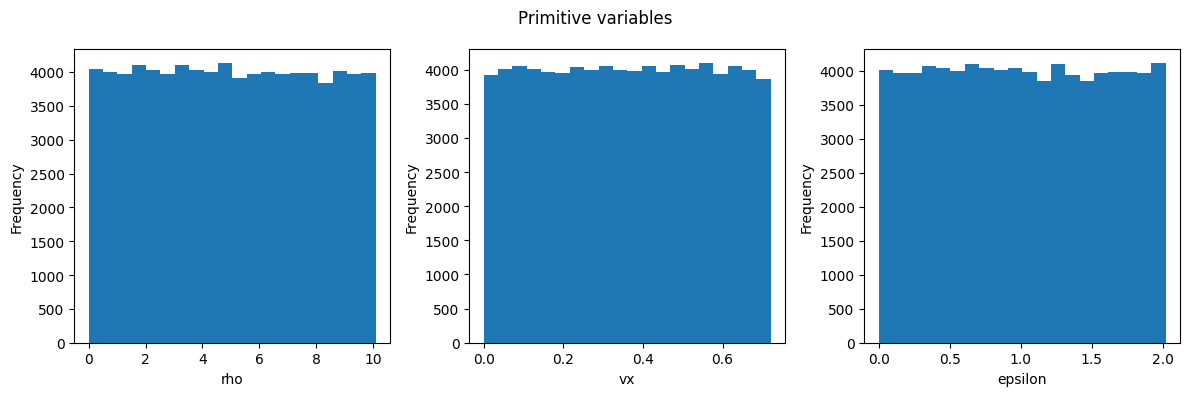

In [ ]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [ ]:

# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 


tensor([2.2363, 4.7878, 0.3077,  ..., 0.2429, 1.0810, 0.8785], device='cuda:0')

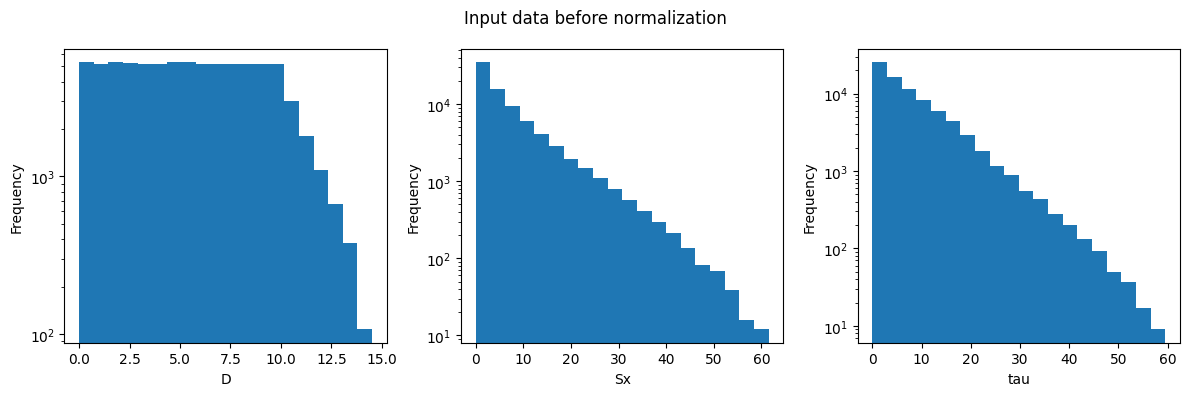

In [ ]:
# Plotting the histograms of the input data before normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data before normalization")
plt.tight_layout()
plt.show()


Perform z-score normalization

In [ ]:
if ZSCORE_NORMALIZATION:
    # Computing the mean and standard deviation of each input variable from the training set
    D_mean = torch.mean(x_train[:, 0])
    D_std = torch.std(x_train[:, 0])
    Sx_mean = torch.mean(x_train[:, 1])
    Sx_std = torch.std(x_train[:, 1])
    tau_mean = torch.mean(x_train[:, 2])
    tau_std = torch.std(x_train[:, 2])

    # Applying z-score normalization to both train and test sets using the statistics from the training set
    x_train[:, 0] = torch.sub(x_train[:, 0], D_mean).div(D_std)
    x_train[:, 1] = torch.sub(x_train[:, 1], Sx_mean).div(Sx_std)
    x_train[:, 2] = torch.sub(x_train[:, 2], tau_mean).div(tau_std)
    x_test[:, 0] = torch.sub(x_test[:, 0], D_mean).div(D_std)
    x_test[:, 1] = torch.sub(x_test[:, 1], Sx_mean).div(Sx_std)
    x_test[:, 2] = torch.sub(x_test[:, 2], tau_mean).div(tau_std)


tensor(5.6155, device='cuda:0')
tensor(3.3241, device='cuda:0')
tensor(6.8519, device='cuda:0')
tensor(8.0748, device='cuda:0')
tensor(8.0121, device='cuda:0')
tensor(7.8353, device='cuda:0')


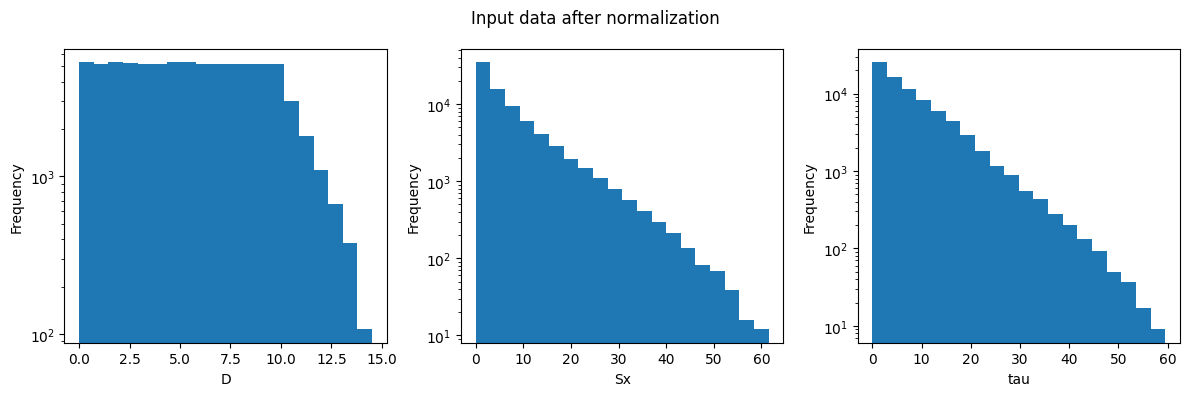

In [ ]:

# Verifying that the means and the stds of the input data are close to 0 and 1 respectively.
print(torch.mean(x_train[:, 0]))
print(torch.std(x_train[:, 0]))
print(torch.mean(x_train[:, 1]))
print(torch.std(x_train[:, 1]))
print(torch.mean(x_train[:, 2]))
print(torch.std(x_train[:, 2]))

# Plotting the histograms of the input data after normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data after normalization")
plt.tight_layout()
plt.show()


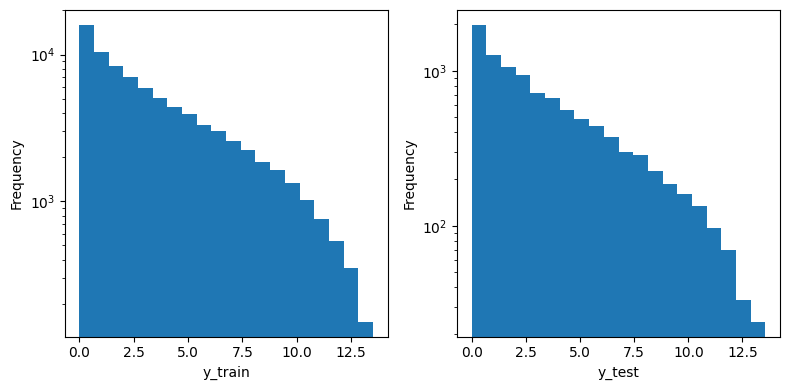

In [ ]:
# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 5)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 1048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            "output_activation", ["ReLU", "Softplus"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 16, 512)
        n_epochs = trial.suggest_int("n_epochs", 50, 200) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if optimize:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
            beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            # Added sampling the step_size and gamma for StepLR
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.05, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            # Added sampling the gamma for ExponentialLR
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            # Added sampling the T_max for CosineAnnealingLR
            T_max = trial.suggest_int("T_max", 5, 15)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.9)
            patience = trial.suggest_int("patience", 5, 15)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            # Added creating the CosineAnnealingLR scheduler
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added creating the ReduceLROnPlateau scheduler
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.5, patience=5, threshold=0.0005, min_lr=1e-6
                    )
        else:
            scheduler = None


    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-14 15:10:05,690] A new study created in memory with name: no-name-26d4c733-b7ed-47da-90e9-e088beda1e65
<ipython-input-28-6132826d8619>:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Epoch 1: Train Loss: 0.1807, Test Loss: 0.0015, Train L1 Norm: 1.6961, Test L1 Norm: 1.8287, Train Linf Norm: 43.0483, Test Linf Norm: 48.9242
Epoch 2: Train Loss: 0.0014, Test Loss: 0.0011, Train L1 Norm: 0.9733, Test L1 Norm: 1.5130, Train Linf Norm: 25.1936, Test Linf Norm: 40.5458
Epoch 3: Train Loss: 0.0009, Test Loss: 0.0009, Train L1 Norm: 0.8334, Test L1 Norm: 1.3831, Train Linf Norm: 21.6385, Test Linf Norm: 37.1134
Epoch 4: Train Loss: 0.0007, Test Loss: 0.0006, Train L1 Norm: 0.7678, Test L1 Norm: 1.2958, Train Linf Norm: 19.8670, Test Linf Norm: 34.8237
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.7253, Test L1 Norm: 1.2369, Train Linf Norm: 18.7438, Test Linf Norm: 33.2711
Epoch 6: Train Loss: 0.0005, Test Loss: 0.0005, Train L1 Norm: 0.6944, Test L1 Norm: 1.1989, Train Linf Norm: 17.9753, Test Linf Norm: 32.2660
Epoch 7: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.6746, Test L1 Norm: 1.1611, Train Linf Norm: 17.4898, Test Linf Norm: 31.2652

[I 2023-05-14 15:24:10,748] Trial 0 finished with value: 0.5865411702962592 and parameters: {'n_layers': 5, 'n_units_0': 432, 'n_units_1': 620, 'n_units_2': 467, 'n_units_3': 452, 'n_units_4': 590, 'hidden_activation': 'ELU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0022682804885048222, 'batch_size': 28, 'n_epochs': 96, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 0 with value: 0.5865411702962592.


Epoch 96: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.3333, Test L1 Norm: 0.5865, Train Linf Norm: 8.8452, Test Linf Norm: 15.9241


<ipython-input-28-6132826d8619>:114: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-28-6132826d8619>:115: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  momentum = trial.suggest_uniform("momentum", 0.0, 0.99)


Epoch 1: Train Loss: 0.4017, Test Loss: 0.1411, Train L1 Norm: 1.1177, Test L1 Norm: 0.4485, Train Linf Norm: 187.1483, Test Linf Norm: 52.6845
Epoch 2: Train Loss: 0.1597, Test Loss: 0.0825, Train L1 Norm: 0.6218, Test L1 Norm: 0.6572, Train Linf Norm: 103.8681, Test Linf Norm: 137.3573
Epoch 3: Train Loss: 0.1358, Test Loss: 0.0769, Train L1 Norm: 0.7564, Test L1 Norm: 1.0082, Train Linf Norm: 156.1092, Test Linf Norm: 257.4392
Epoch 4: Train Loss: 0.1114, Test Loss: 0.1038, Train L1 Norm: 0.9400, Test L1 Norm: 1.2751, Train Linf Norm: 216.5276, Test Linf Norm: 336.0442
Epoch 5: Train Loss: 0.0951, Test Loss: 0.0532, Train L1 Norm: 1.0037, Test L1 Norm: 1.3047, Train Linf Norm: 225.6651, Test Linf Norm: 357.5952
Epoch 6: Train Loss: 0.0815, Test Loss: 0.0564, Train L1 Norm: 0.9290, Test L1 Norm: 1.2506, Train Linf Norm: 214.1115, Test Linf Norm: 338.5194
Epoch 7: Train Loss: 0.0688, Test Loss: 0.0227, Train L1 Norm: 0.9107, Test L1 Norm: 1.1757, Train Linf Norm: 214.2741, Test Linf N

[I 2023-05-14 15:25:14,492] Trial 1 finished with value: 0.8067422926083208 and parameters: {'n_layers': 2, 'n_units_0': 411, 'n_units_1': 627, 'hidden_activation': 'Tanh', 'output_activation': 'Softplus', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.007968178276828983, 'batch_size': 374, 'n_epochs': 60, 'scheduler': 'None', 'weight_decay': 1.128833969501318e-05, 'momentum': 0.5040209727759072}. Best is trial 0 with value: 0.5865411702962592.


Epoch 60: Train Loss: 0.0043, Test Loss: 0.0010, Train L1 Norm: 0.5770, Test L1 Norm: 0.8067, Train Linf Norm: 148.2919, Test Linf Norm: 229.5496


<ipython-input-28-6132826d8619>:137: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)


Epoch 1: Train Loss: 0.5271, Test Loss: 0.0812, Train L1 Norm: 6.1531, Test L1 Norm: 9.7784, Train Linf Norm: 1792.6561, Test Linf Norm: 3169.6961
Epoch 2: Train Loss: 0.0672, Test Loss: 0.0563, Train L1 Norm: 5.2754, Test L1 Norm: 9.1655, Train Linf Norm: 1525.2713, Test Linf Norm: 2978.9623
Epoch 3: Train Loss: 0.0498, Test Loss: 0.0441, Train L1 Norm: 4.9610, Test L1 Norm: 8.7172, Train Linf Norm: 1449.6159, Test Linf Norm: 2840.4462
Epoch 4: Train Loss: 0.0413, Test Loss: 0.0387, Train L1 Norm: 4.7270, Test L1 Norm: 8.3836, Train Linf Norm: 1402.9312, Test Linf Norm: 2736.3836
Epoch 5: Train Loss: 0.0363, Test Loss: 0.0342, Train L1 Norm: 4.5676, Test L1 Norm: 8.1380, Train Linf Norm: 1378.9209, Test Linf Norm: 2658.6883
Epoch 6: Train Loss: 0.0331, Test Loss: 0.0333, Train L1 Norm: 4.4255, Test L1 Norm: 7.9275, Train Linf Norm: 1322.9458, Test Linf Norm: 2592.1518
Epoch 7: Train Loss: 0.0308, Test Loss: 0.0296, Train L1 Norm: 4.3213, Test L1 Norm: 7.7618, Train Linf Norm: 1271.772

[I 2023-05-14 15:26:44,245] Trial 2 finished with value: 5.8818315732777116 and parameters: {'n_layers': 2, 'n_units_0': 437, 'n_units_1': 943, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.00012673357393118108, 'batch_size': 410, 'n_epochs': 86, 'scheduler': 'ExponentialLR', 'weight_decay': 1.4164270583452917e-05, 'momentum': 0.775675507443574, 'gamma': 0.9588231183614683}. Best is trial 0 with value: 0.5865411702962592.


Epoch 86: Train Loss: 0.0140, Test Loss: 0.0138, Train L1 Norm: 3.2049, Test L1 Norm: 5.8818, Train Linf Norm: 963.9566, Test Linf Norm: 1935.3200
Epoch 1: Train Loss: 0.6747, Test Loss: 0.0765, Train L1 Norm: 6.5246, Test L1 Norm: 10.3223, Train Linf Norm: 1347.3850, Test Linf Norm: 2410.3774
Epoch 2: Train Loss: 0.0585, Test Loss: 0.0473, Train L1 Norm: 5.5231, Test L1 Norm: 9.4772, Train Linf Norm: 1191.4746, Test Linf Norm: 2225.6784
Epoch 3: Train Loss: 0.0424, Test Loss: 0.0382, Train L1 Norm: 5.1885, Test L1 Norm: 9.0857, Train Linf Norm: 1117.4118, Test Linf Norm: 2140.5962
Epoch 4: Train Loss: 0.0365, Test Loss: 0.0342, Train L1 Norm: 4.9800, Test L1 Norm: 8.8153, Train Linf Norm: 1092.0856, Test Linf Norm: 2080.9055
Epoch 5: Train Loss: 0.0332, Test Loss: 0.0314, Train L1 Norm: 4.8407, Test L1 Norm: 8.5854, Train Linf Norm: 1026.4454, Test Linf Norm: 2029.4591
Epoch 6: Train Loss: 0.0306, Test Loss: 0.0293, Train L1 Norm: 4.6997, Test L1 Norm: 8.3875, Train Linf Norm: 1033.40

[I 2023-05-14 15:29:58,627] Trial 3 finished with value: 2.326351450005174 and parameters: {'n_layers': 3, 'n_units_0': 189, 'n_units_1': 475, 'n_units_2': 80, 'hidden_activation': 'ReLU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.0004193479804619356, 'batch_size': 291, 'n_epochs': 162, 'scheduler': 'None', 'weight_decay': 0.00017443627760781267, 'momentum': 0.7094138805847873}. Best is trial 0 with value: 0.5865411702962592.


Epoch 162: Train Loss: 0.0010, Test Loss: 0.0010, Train L1 Norm: 1.2503, Test L1 Norm: 2.3264, Train Linf Norm: 287.4723, Test Linf Norm: 565.1288


<ipython-input-28-6132826d8619>:145: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-28-6132826d8619>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1: Train Loss: 0.1072, Test Loss: 0.0292, Train L1 Norm: 0.4428, Test L1 Norm: 0.1336, Train Linf Norm: 95.3787, Test Linf Norm: 23.9688
Epoch 2: Train Loss: 0.0202, Test Loss: 0.0309, Train L1 Norm: 0.1777, Test L1 Norm: 0.3765, Train Linf Norm: 42.3478, Test Linf Norm: 104.9819
Epoch 3: Train Loss: 0.0176, Test Loss: 0.0031, Train L1 Norm: 0.1346, Test L1 Norm: 0.0416, Train Linf Norm: 28.0165, Test Linf Norm: 2.1084
Epoch 4: Train Loss: 0.0139, Test Loss: 0.0012, Train L1 Norm: 0.1085, Test L1 Norm: 0.0348, Train Linf Norm: 21.2107, Test Linf Norm: 4.5860
Epoch 5: Train Loss: 0.0149, Test Loss: 0.0080, Train L1 Norm: 0.1069, Test L1 Norm: 0.1946, Train Linf Norm: 17.4469, Test Linf Norm: 55.1807
Epoch 6: Train Loss: 0.0116, Test Loss: 0.0735, Train L1 Norm: 0.1022, Test L1 Norm: 0.2740, Train Linf Norm: 20.5074, Test Linf Norm: 51.2463
Epoch 7: Train Loss: 0.0114, Test Loss: 0.0051, Train L1 Norm: 0.1052, Test L1 Norm: 0.0421, Train Linf Norm: 19.6540, Test Linf Norm: 2.4624
E

[I 2023-05-14 15:32:45,550] Trial 4 finished with value: 0.005258353637764231 and parameters: {'n_layers': 3, 'n_units_0': 66, 'n_units_1': 648, 'n_units_2': 200, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00017004241653571694, 'batch_size': 510, 'n_epochs': 166, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.39592842352805846, 'patience': 13, 'threshold': 0.0017050843410359648}. Best is trial 4 with value: 0.005258353637764231.


Epoch 166: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0101, Test L1 Norm: 0.0053, Train Linf Norm: 1.9717, Test Linf Norm: 0.5736


[I 2023-05-14 15:32:48,383] Trial 5 pruned. 


Epoch 1: Train Loss: 9.3404, Test Loss: 8.9929, Train L1 Norm: 29.3173, Test L1 Norm: 53.4301, Train Linf Norm: 1860.7295, Test Linf Norm: 3533.9593


[I 2023-05-14 15:32:49,461] Trial 6 pruned. 


Epoch 1: Train Loss: 1.4035, Test Loss: 1.0829, Train L1 Norm: 7.1314, Test L1 Norm: 9.6115, Train Linf Norm: 1700.8582, Test Linf Norm: 2763.9355
Epoch 1: Train Loss: 0.7165, Test Loss: 0.3994, Train L1 Norm: 1.6287, Test L1 Norm: 0.6367, Train Linf Norm: 142.8376, Test Linf Norm: 47.1092
Epoch 2: Train Loss: 0.3210, Test Loss: 0.4600, Train L1 Norm: 1.0223, Test L1 Norm: 1.8271, Train Linf Norm: 96.7096, Test Linf Norm: 177.1161
Epoch 3: Train Loss: 0.2731, Test Loss: 0.1568, Train L1 Norm: 0.9279, Test L1 Norm: 1.1094, Train Linf Norm: 88.4210, Test Linf Norm: 115.1110
Epoch 4: Train Loss: 0.2405, Test Loss: 0.2968, Train L1 Norm: 0.7548, Test L1 Norm: 1.1151, Train Linf Norm: 70.5031, Test Linf Norm: 107.8964
Epoch 5: Train Loss: 0.2165, Test Loss: 0.1846, Train L1 Norm: 0.6939, Test L1 Norm: 0.8938, Train Linf Norm: 64.9525, Test Linf Norm: 90.4632
Epoch 6: Train Loss: 0.1987, Test Loss: 0.1558, Train L1 Norm: 0.6609, Test L1 Norm: 0.8713, Train Linf Norm: 62.4293, Test Linf Norm:

[I 2023-05-14 15:37:10,652] Trial 7 pruned. 


Epoch 163: Train Loss: 0.0555, Test Loss: 0.0558, Train L1 Norm: 0.2882, Test L1 Norm: 0.4625, Train Linf Norm: 30.0602, Test Linf Norm: 49.2980
Epoch 1: Train Loss: 2.9420, Test Loss: 2.9469, Train L1 Norm: 1.0213, Test L1 Norm: 1.0000, Train Linf Norm: 1.4757, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: 

[I 2023-05-14 15:38:07,209] Trial 8 pruned. 


Epoch 25: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 149.3844, Test Loss: 3.3932, Train L1 Norm: 98.8847, Test L1 Norm: 1.0000, Train Linf Norm: 7156.8879, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 

[I 2023-05-14 15:38:39,465] Trial 9 pruned. 


Epoch 25: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


<ipython-input-28-6132826d8619>:119: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-28-6132826d8619>:120: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
<ipython-input-28-6132826d8619>:121: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
<ipython-input-28-6132826d8619>:133: FutureWarning: suggest_unifor

Epoch 1: Train Loss: 0.2048, Test Loss: 0.0020, Train L1 Norm: 1.3135, Test L1 Norm: 0.8880, Train Linf Norm: 416.8769, Test Linf Norm: 353.3035
Epoch 2: Train Loss: 0.0023, Test Loss: 0.0011, Train L1 Norm: 0.5237, Test L1 Norm: 0.7241, Train Linf Norm: 180.1274, Test Linf Norm: 290.5095
Epoch 3: Train Loss: 0.0017, Test Loss: 0.0014, Train L1 Norm: 0.3608, Test L1 Norm: 0.4782, Train Linf Norm: 129.3385, Test Linf Norm: 190.7365
Epoch 4: Train Loss: 0.0020, Test Loss: 0.0011, Train L1 Norm: 0.2924, Test L1 Norm: 0.4200, Train Linf Norm: 100.8935, Test Linf Norm: 166.3184
Epoch 5: Train Loss: 0.0022, Test Loss: 0.0019, Train L1 Norm: 0.2780, Test L1 Norm: 0.3739, Train Linf Norm: 98.7139, Test Linf Norm: 146.2327
Epoch 6: Train Loss: 0.0018, Test Loss: 0.0011, Train L1 Norm: 0.2411, Test L1 Norm: 0.2878, Train Linf Norm: 82.8072, Test Linf Norm: 111.5807
Epoch 7: Train Loss: 0.0017, Test Loss: 0.0035, Train L1 Norm: 0.2028, Test L1 Norm: 0.2722, Train Linf Norm: 68.5176, Test Linf Nor

[I 2023-05-14 15:41:31,252] Trial 10 finished with value: 0.18515829190351069 and parameters: {'n_layers': 4, 'n_units_0': 682, 'n_units_1': 42, 'n_units_2': 36, 'n_units_3': 1042, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.0006086546767505102, 'batch_size': 501, 'n_epochs': 158, 'scheduler': 'StepLR', 'weight_decay': 0.009137258195901096, 'beta1': 0.9131575048738748, 'beta2': 0.9381685578474619, 'step_size': 7, 'gamma': 0.06387486747650886}. Best is trial 4 with value: 0.005258353637764231.


Epoch 158: Train Loss: 0.0008, Test Loss: 0.0009, Train L1 Norm: 0.1456, Test L1 Norm: 0.1852, Train Linf Norm: 51.0034, Test Linf Norm: 70.1479
Epoch 1: Train Loss: 0.1875, Test Loss: 0.0070, Train L1 Norm: 1.1050, Test L1 Norm: 0.9340, Train Linf Norm: 342.6965, Test Linf Norm: 355.2114
Epoch 2: Train Loss: 0.0021, Test Loss: 0.0008, Train L1 Norm: 0.4962, Test L1 Norm: 0.7201, Train Linf Norm: 175.2853, Test Linf Norm: 280.9884
Epoch 3: Train Loss: 0.0018, Test Loss: 0.0017, Train L1 Norm: 0.3711, Test L1 Norm: 0.5309, Train Linf Norm: 132.7858, Test Linf Norm: 204.7377
Epoch 4: Train Loss: 0.0017, Test Loss: 0.0024, Train L1 Norm: 0.2745, Test L1 Norm: 0.3522, Train Linf Norm: 88.5645, Test Linf Norm: 132.7773
Epoch 5: Train Loss: 0.0016, Test Loss: 0.0008, Train L1 Norm: 0.2160, Test L1 Norm: 0.2253, Train Linf Norm: 76.0183, Test Linf Norm: 82.6410
Epoch 6: Train Loss: 0.0016, Test Loss: 0.0045, Train L1 Norm: 0.1536, Test L1 Norm: 0.1257, Train Linf Norm: 48.3825, Test Linf Norm

[I 2023-05-14 15:44:23,465] Trial 11 finished with value: 0.04125696425884962 and parameters: {'n_layers': 4, 'n_units_0': 715, 'n_units_1': 44, 'n_units_2': 49, 'n_units_3': 1011, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.0006348648086716921, 'batch_size': 492, 'n_epochs': 157, 'scheduler': 'StepLR', 'weight_decay': 0.006810042193361624, 'beta1': 0.9011880219516433, 'beta2': 0.9381143075324843, 'step_size': 7, 'gamma': 0.06426243173398248}. Best is trial 4 with value: 0.005258353637764231.


Epoch 157: Train Loss: 0.0006, Test Loss: 0.0006, Train L1 Norm: 0.0781, Test L1 Norm: 0.0413, Train Linf Norm: 23.7841, Test Linf Norm: 7.5535
Epoch 1: Train Loss: 0.4926, Test Loss: 0.0080, Train L1 Norm: 0.7186, Test L1 Norm: 0.0957, Train Linf Norm: 130.6309, Test Linf Norm: 6.2595
Epoch 2: Train Loss: 0.0025, Test Loss: 0.0044, Train L1 Norm: 0.1086, Test L1 Norm: 0.1256, Train Linf Norm: 27.0357, Test Linf Norm: 34.9544
Epoch 3: Train Loss: 0.0019, Test Loss: 0.0020, Train L1 Norm: 0.1164, Test L1 Norm: 0.1587, Train Linf Norm: 35.8842, Test Linf Norm: 53.3029
Epoch 4: Train Loss: 0.0016, Test Loss: 0.0079, Train L1 Norm: 0.1224, Test L1 Norm: 0.2072, Train Linf Norm: 38.8147, Test Linf Norm: 64.8534
Epoch 5: Train Loss: 0.0017, Test Loss: 0.0008, Train L1 Norm: 0.1133, Test L1 Norm: 0.1442, Train Linf Norm: 34.0379, Test Linf Norm: 51.0360
Epoch 6: Train Loss: 0.0015, Test Loss: 0.0017, Train L1 Norm: 0.1107, Test L1 Norm: 0.1499, Train Linf Norm: 34.8632, Test Linf Norm: 50.812

[I 2023-05-14 15:47:19,829] Trial 12 pruned. 


Epoch 163: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0887, Test L1 Norm: 0.1170, Train Linf Norm: 26.9143, Test Linf Norm: 41.5403


[I 2023-05-14 15:47:21,010] Trial 13 pruned. 


Epoch 1: Train Loss: 0.0835, Test Loss: 0.0077, Train L1 Norm: 1.6370, Test L1 Norm: 3.1018, Train Linf Norm: 512.1879, Test Linf Norm: 1145.1692


[I 2023-05-14 15:47:22,424] Trial 14 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1488, Test Loss: 0.0033, Train L1 Norm: 0.5852, Test L1 Norm: 0.1814, Train Linf Norm: 156.1566, Test Linf Norm: 46.6089
Epoch 2: Train Loss: 0.0027, Test Loss: 0.0013, Train L1 Norm: 0.1452, Test L1 Norm: 0.0595, Train Linf Norm: 38.7812, Test Linf Norm: 10.6200
Epoch 3: Train Loss: 0.0012, Test Loss: 0.0004, Train L1 Norm: 0.0798, Test L1 Norm: 0.0449, Train Linf Norm: 18.7504, Test Linf Norm: 8.6410
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0541, Test L1 Norm: 0.0450, Train Linf Norm: 11.9833, Test Linf Norm: 9.4616
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0478, Test L1 Norm: 0.0307, Train Linf Norm: 11.2369, Test Linf Norm: 5.8622
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0404, Test L1 Norm: 0.0291, Train Linf Norm: 9.2238, Test Linf Norm: 5.6827
Epoch

[I 2023-05-14 15:50:13,380] Trial 15 finished with value: 0.005089756968664006 and parameters: {'n_layers': 4, 'n_units_0': 589, 'n_units_1': 782, 'n_units_2': 234, 'n_units_3': 728, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0002447626241316691, 'batch_size': 450, 'n_epochs': 144, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.3615203877131656, 'patience': 15, 'threshold': 0.00013041305807954143}. Best is trial 15 with value: 0.005089756968664006.


Epoch 144: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0064, Test L1 Norm: 0.0051, Train Linf Norm: 1.3518, Test Linf Norm: 0.7532


[I 2023-05-14 15:50:14,668] Trial 16 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2183, Test Loss: 0.0068, Train L1 Norm: 0.5568, Test L1 Norm: 0.3797, Train Linf Norm: 113.1824, Test Linf Norm: 115.4975
Epoch 2: Train Loss: 0.0043, Test Loss: 0.0017, Train L1 Norm: 0.2583, Test L1 Norm: 0.2608, Train Linf Norm: 74.6884, Test Linf Norm: 81.7489
Epoch 3: Train Loss: 0.0016, Test Loss: 0.0028, Train L1 Norm: 0.1647, Test L1 Norm: 0.1125, Train Linf Norm: 47.0527, Test Linf Norm: 30.2065
Epoch 4: Train Loss: 0.0009, Test Loss: 0.0005, Train L1 Norm: 0.1036, Test L1 Norm: 0.0801, Train Linf Norm: 28.7822, Test Linf Norm: 19.7015
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0798, Test L1 Norm: 0.0550, Train Linf Norm: 21.1479, Test Linf Norm: 12.9496
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0004, Train L1 Norm: 0.0672, Test L1 Norm: 0.0869, Train Linf Norm: 18.8969, Test Linf Norm: 25.2445

[I 2023-05-14 15:53:33,544] Trial 17 pruned. 


Epoch 165: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0086, Test L1 Norm: 0.0066, Train Linf Norm: 2.0071, Test Linf Norm: 1.1835
Epoch 1: Train Loss: 0.0941, Test Loss: 0.0145, Train L1 Norm: 0.3476, Test L1 Norm: 0.1713, Train Linf Norm: 45.6842, Test Linf Norm: 22.0738
Epoch 2: Train Loss: 0.0074, Test Loss: 0.0045, Train L1 Norm: 0.2600, Test L1 Norm: 0.4643, Train Linf Norm: 52.5833, Test Linf Norm: 125.7717
Epoch 3: Train Loss: 0.0036, Test Loss: 0.0026, Train L1 Norm: 0.2754, Test L1 Norm: 0.3005, Train Linf Norm: 63.9859, Test Linf Norm: 78.8437
Epoch 4: Train Loss: 0.0022, Test Loss: 0.0017, Train L1 Norm: 0.1877, Test L1 Norm: 0.1764, Train Linf Norm: 41.8947, Test Linf Norm: 42.2443
Epoch 5: Train Loss: 0.0015, Test Loss: 0.0012, Train L1 Norm: 0.1202, Test L1 Norm: 0.0919, Train Linf Norm: 24.1331, Test Linf Norm: 16.9091
Epoch 6: Train Loss: 0.0011, Test Loss: 0.0009, Train L1 Norm: 0.0885, Test L1 Norm: 0.0597, Train Linf Norm: 15.7467, Test Linf Norm: 7.6200

[I 2023-05-14 15:56:03,000] Trial 18 finished with value: 0.05779615726638585 and parameters: {'n_layers': 3, 'n_units_0': 863, 'n_units_1': 763, 'n_units_2': 580, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0001019797141812919, 'batch_size': 342, 'n_epochs': 122, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.6179840395818954, 'patience': 12, 'threshold': 0.0001224387425376439}. Best is trial 15 with value: 0.005089756968664006.


Epoch 122: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0390, Test L1 Norm: 0.0578, Train Linf Norm: 7.4116, Test Linf Norm: 13.8903
Epoch 1: Train Loss: 0.5585, Test Loss: 0.1432, Train L1 Norm: 0.4110, Test L1 Norm: 0.1197, Train Linf Norm: 42.4763, Test Linf Norm: 15.1296
Epoch 2: Train Loss: 0.2296, Test Loss: 0.2563, Train L1 Norm: 0.1689, Test L1 Norm: 0.1055, Train Linf Norm: 21.1307, Test Linf Norm: 2.5737
Epoch 3: Train Loss: 0.1926, Test Loss: 0.1409, Train L1 Norm: 0.1668, Test L1 Norm: 0.1307, Train Linf Norm: 26.7567, Test Linf Norm: 19.2436
Epoch 4: Train Loss: 0.1708, Test Loss: 0.2257, Train L1 Norm: 0.1519, Test L1 Norm: 0.1028, Train Linf Norm: 25.7653, Test Linf Norm: 1.0644
Epoch 5: Train Loss: 0.1559, Test Loss: 0.1220, Train L1 Norm: 0.1291, Test L1 Norm: 0.1082, Train Linf Norm: 18.6535, Test Linf Norm: 14.8726
Epoch 6: Train Loss: 0.1465, Test Loss: 0.2149, Train L1 Norm: 0.1185, Test L1 Norm: 0.0856, Train Linf Norm: 16.7867, Test Linf Norm: 2.4241
E

[I 2023-05-14 15:58:30,594] Trial 19 finished with value: 0.02334400656707585 and parameters: {'n_layers': 2, 'n_units_0': 291, 'n_units_1': 1019, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00037906889218502, 'batch_size': 442, 'n_epochs': 143, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.8927518877037369, 'patience': 8, 'threshold': 0.0019519006365546511}. Best is trial 15 with value: 0.005089756968664006.


Epoch 143: Train Loss: 0.0180, Test Loss: 0.0218, Train L1 Norm: 0.0136, Test L1 Norm: 0.0233, Train Linf Norm: 1.5951, Test Linf Norm: 4.7189


[I 2023-05-14 15:58:32,452] Trial 20 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.4116, Test Loss: 0.2022, Train L1 Norm: 0.4010, Test L1 Norm: 0.1279, Train Linf Norm: 61.3878, Test Linf Norm: 1.3597
Epoch 2: Train Loss: 0.1997, Test Loss: 0.1750, Train L1 Norm: 0.1556, Test L1 Norm: 0.1395, Train Linf Norm: 12.1946, Test Linf Norm: 15.6873
Epoch 3: Train Loss: 0.1722, Test Loss: 0.1720, Train L1 Norm: 0.1441, Test L1 Norm: 0.1108, Train Linf Norm: 14.2889, Test Linf Norm: 1.0524
Epoch 4: Train Loss: 0.1567, Test Loss: 0.1277, Train L1 Norm: 0.1292, Test L1 Norm: 0.1010, Train Linf Norm: 11.9361, Test Linf Norm: 9.6466
Epoch 5: Train Loss: 0.1459, Test Loss: 0.1445, Train L1 Norm: 0.1219, Test L1 Norm: 0.1003, Train Linf Norm: 12.4174, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.1363, Test Loss: 0.1200, Train L1 Norm: 0.1019, Test L1 Norm: 0.1392, Train Linf Norm: 6.3464, Test Linf Norm: 25.6975
Epoch 

[I 2023-05-14 16:00:58,097] Trial 21 finished with value: 0.014768510235473514 and parameters: {'n_layers': 2, 'n_units_0': 54, 'n_units_1': 998, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0003531521026932953, 'batch_size': 452, 'n_epochs': 143, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.8707621358402171, 'patience': 8, 'threshold': 0.0020354083715588413}. Best is trial 15 with value: 0.005089756968664006.


Epoch 143: Train Loss: 0.0229, Test Loss: 0.0246, Train L1 Norm: 0.0248, Test L1 Norm: 0.0148, Train Linf Norm: 4.1299, Test Linf Norm: 0.8920


[I 2023-05-14 16:00:59,097] Trial 22 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:01:00,335] Trial 23 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:01:01,280] Trial 24 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:01:02,542] Trial 25 pruned. 


Epoch 1: Train Loss: 0.5004, Test Loss: 0.3105, Train L1 Norm: 0.6775, Test L1 Norm: 0.5818, Train Linf Norm: 118.2329, Test Linf Norm: 128.5795


[I 2023-05-14 16:01:03,787] Trial 26 pruned. 


Epoch 1: Train Loss: 1.8578, Test Loss: 1.7760, Train L1 Norm: 20.3259, Test L1 Norm: 33.3314, Train Linf Norm: 5009.0920, Test Linf Norm: 9274.6941


[I 2023-05-14 16:01:04,905] Trial 27 pruned. 


Epoch 1: Train Loss: 3.3919, Test Loss: 3.3932, Train L1 Norm: 1.0635, Test L1 Norm: 1.0000, Train Linf Norm: 8.8981, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1317, Test Loss: 0.0418, Train L1 Norm: 0.4780, Test L1 Norm: 0.3031, Train Linf Norm: 74.4020, Test Linf Norm: 45.9135
Epoch 2: Train Loss: 0.0368, Test Loss: 0.1331, Train L1 Norm: 0.1882, Test L1 Norm: 0.1586, Train Linf Norm: 24.9064, Test Linf Norm: 2.5908
Epoch 3: Train Loss: 0.0293, Test Loss: 0.0020, Train L1 Norm: 0.1465, Test L1 Norm: 0.0365, Train Linf Norm: 17.7257, Test Linf Norm: 3.7809
Epoch 4: Train Loss: 0.0254, Test Loss: 0.0495, Train L1 Norm: 0.1231, Test L1 Norm: 0.1140, Train Linf Norm: 13.1023, Test Linf Norm: 6.1030
Epoch 5: Train Loss: 0.0226, Test Loss: 0.0007, Train L1 Norm: 0.1254, Test L1 Norm: 0.0442, Train Linf Norm: 14.3100, Test Linf Norm: 7.2806
Epoch 6: Train Loss: 0.0196, Test Loss: 0.0055, Train L1 Norm: 0.1232, Test L1 Norm: 0.0664, Train Linf Norm: 15.5023, Test Linf Norm: 8.2357
Epoch 

[I 2023-05-14 16:04:03,481] Trial 28 finished with value: 0.0034589410951943135 and parameters: {'n_layers': 4, 'n_units_0': 570, 'n_units_1': 706, 'n_units_2': 323, 'n_units_3': 235, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00014445292867375437, 'batch_size': 263, 'n_epochs': 132, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.3933100194479501, 'patience': 10, 'threshold': 0.001204084720177967}. Best is trial 28 with value: 0.0034589410951943135.


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0052, Test L1 Norm: 0.0035, Train Linf Norm: 0.6443, Test Linf Norm: 0.3505
Epoch 1: Train Loss: 0.2198, Test Loss: 0.0198, Train L1 Norm: 0.5345, Test L1 Norm: 0.2311, Train Linf Norm: 54.0652, Test Linf Norm: 23.7132
Epoch 2: Train Loss: 0.0101, Test Loss: 0.0057, Train L1 Norm: 0.4324, Test L1 Norm: 0.9292, Train Linf Norm: 78.1584, Test Linf Norm: 194.4896
Epoch 3: Train Loss: 0.0044, Test Loss: 0.0034, Train L1 Norm: 0.5269, Test L1 Norm: 0.9020, Train Linf Norm: 101.6512, Test Linf Norm: 191.8295
Epoch 4: Train Loss: 0.0025, Test Loss: 0.0027, Train L1 Norm: 0.4660, Test L1 Norm: 0.7733, Train Linf Norm: 88.1338, Test Linf Norm: 164.8802


[I 2023-05-14 16:04:11,478] Trial 29 pruned. 


Epoch 5: Train Loss: 0.0017, Test Loss: 0.0014, Train L1 Norm: 0.4023, Test L1 Norm: 0.6668, Train Linf Norm: 80.2271, Test Linf Norm: 142.3062


[I 2023-05-14 16:04:13,696] Trial 30 pruned. 


Epoch 1: Train Loss: 1.1298, Test Loss: 0.0388, Train L1 Norm: 1.4913, Test L1 Norm: 1.0152, Train Linf Norm: 150.4325, Test Linf Norm: 125.3807
Epoch 1: Train Loss: 0.1231, Test Loss: 0.0217, Train L1 Norm: 0.4055, Test L1 Norm: 0.0930, Train Linf Norm: 56.1891, Test Linf Norm: 6.4282
Epoch 2: Train Loss: 0.0304, Test Loss: 0.0035, Train L1 Norm: 0.1457, Test L1 Norm: 0.0507, Train Linf Norm: 15.7819, Test Linf Norm: 4.5471
Epoch 3: Train Loss: 0.0245, Test Loss: 0.0122, Train L1 Norm: 0.1482, Test L1 Norm: 0.0614, Train Linf Norm: 19.4101, Test Linf Norm: 3.2494
Epoch 4: Train Loss: 0.0200, Test Loss: 0.0174, Train L1 Norm: 0.1166, Test L1 Norm: 0.1926, Train Linf Norm: 14.2666, Test Linf Norm: 29.9741
Epoch 5: Train Loss: 0.0169, Test Loss: 0.0075, Train L1 Norm: 0.0870, Test L1 Norm: 0.1304, Train Linf Norm: 8.0487, Test Linf Norm: 18.9541
Epoch 6: Train Loss: 0.0163, Test Loss: 0.0089, Train L1 Norm: 0.1027, Test L1 Norm: 0.0506, Train Linf Norm: 12.7531, Test Linf Norm: 0.9809
Ep

[I 2023-05-14 16:07:09,370] Trial 31 finished with value: 0.003140649275132455 and parameters: {'n_layers': 4, 'n_units_0': 501, 'n_units_1': 820, 'n_units_2': 161, 'n_units_3': 16, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00021452940608956487, 'batch_size': 274, 'n_epochs': 134, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.2674226235631022, 'patience': 10, 'threshold': 0.0013273847507923606}. Best is trial 31 with value: 0.003140649275132455.


Epoch 134: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0046, Test L1 Norm: 0.0031, Train Linf Norm: 0.5478, Test Linf Norm: 0.3644
Epoch 1: Train Loss: 0.1348, Test Loss: 0.0327, Train L1 Norm: 0.2974, Test L1 Norm: 0.2048, Train Linf Norm: 25.5942, Test Linf Norm: 24.8133
Epoch 2: Train Loss: 0.0345, Test Loss: 0.0316, Train L1 Norm: 0.1582, Test L1 Norm: 0.0797, Train Linf Norm: 17.0339, Test Linf Norm: 1.0654
Epoch 3: Train Loss: 0.0275, Test Loss: 0.0051, Train L1 Norm: 0.1394, Test L1 Norm: 0.1322, Train Linf Norm: 14.8782, Test Linf Norm: 22.1707
Epoch 4: Train Loss: 0.0231, Test Loss: 0.0021, Train L1 Norm: 0.1211, Test L1 Norm: 0.0358, Train Linf Norm: 12.7944, Test Linf Norm: 2.7668
Epoch 5: Train Loss: 0.0196, Test Loss: 0.0023, Train L1 Norm: 0.1217, Test L1 Norm: 0.0649, Train Linf Norm: 14.6569, Test Linf Norm: 10.4338
Epoch 6: Train Loss: 0.0179, Test Loss: 0.1586, Train L1 Norm: 0.1116, Test L1 Norm: 0.1758, Train Linf Norm: 12.7353, Test Linf Norm: 0.9831
Ep

[I 2023-05-14 16:10:03,226] Trial 32 finished with value: 0.0036905216951854526 and parameters: {'n_layers': 4, 'n_units_0': 488, 'n_units_1': 822, 'n_units_2': 141, 'n_units_3': 71, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00021784884053226408, 'batch_size': 270, 'n_epochs': 131, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.24116955407149346, 'patience': 10, 'threshold': 0.0012468664737308045}. Best is trial 31 with value: 0.003140649275132455.


Epoch 131: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0041, Test L1 Norm: 0.0037, Train Linf Norm: 0.5545, Test Linf Norm: 0.4118


[I 2023-05-14 16:10:04,581] Trial 33 pruned. 


Epoch 1: Train Loss: 0.1046, Test Loss: 0.0974, Train L1 Norm: 0.3544, Test L1 Norm: 0.3228, Train Linf Norm: 46.8050, Test Linf Norm: 36.0111


[I 2023-05-14 16:10:06,049] Trial 34 pruned. 


Epoch 1: Train Loss: 0.1197, Test Loss: 0.0139, Train L1 Norm: 1.1620, Test L1 Norm: 0.8809, Train Linf Norm: 174.6718, Test Linf Norm: 152.1028
Epoch 1: Train Loss: 0.0507, Test Loss: 0.0019, Train L1 Norm: 0.1821, Test L1 Norm: 0.0376, Train Linf Norm: 2.4290, Test Linf Norm: 0.4103
Epoch 2: Train Loss: 0.0143, Test Loss: 0.0007, Train L1 Norm: 0.1006, Test L1 Norm: 0.0731, Train Linf Norm: 1.4244, Test Linf Norm: 1.2644
Epoch 3: Train Loss: 0.0103, Test Loss: 0.0002, Train L1 Norm: 0.0724, Test L1 Norm: 0.0227, Train Linf Norm: 0.9795, Test Linf Norm: 0.2881
Epoch 4: Train Loss: 0.0081, Test Loss: 0.0140, Train L1 Norm: 0.0722, Test L1 Norm: 0.1530, Train Linf Norm: 1.0460, Test Linf Norm: 2.3185
Epoch 5: Train Loss: 0.0065, Test Loss: 0.0001, Train L1 Norm: 0.0707, Test L1 Norm: 0.0214, Train Linf Norm: 1.0707, Test Linf Norm: 0.3277
Epoch 6: Train Loss: 0.0055, Test Loss: 0.0001, Train L1 Norm: 0.0559, Test L1 Norm: 0.0173, Train Linf Norm: 0.8016, Test Linf Norm: 0.2349
Epoch 7: 

[I 2023-05-14 16:30:42,854] Trial 35 finished with value: 0.003997663051937707 and parameters: {'n_layers': 5, 'n_units_0': 631, 'n_units_1': 809, 'n_units_2': 143, 'n_units_3': 165, 'n_units_4': 999, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0002320075363883172, 'batch_size': 20, 'n_epochs': 130, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.1991464604902632, 'patience': 10, 'threshold': 0.0010721480211898476}. Best is trial 31 with value: 0.003140649275132455.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0029, Test L1 Norm: 0.0040, Train Linf Norm: 0.0439, Test Linf Norm: 0.0652


[I 2023-05-14 16:30:49,050] Trial 36 pruned. 


Epoch 1: Train Loss: 0.2284, Test Loss: 0.0129, Train L1 Norm: 0.3841, Test L1 Norm: 0.2446, Train Linf Norm: 9.4760, Test Linf Norm: 6.7831


[I 2023-05-14 16:30:50,452] Trial 37 pruned. 


Epoch 1: Train Loss: 0.1273, Test Loss: 0.0404, Train L1 Norm: 0.4489, Test L1 Norm: 0.3578, Train Linf Norm: 68.4896, Test Linf Norm: 61.9356


[I 2023-05-14 16:30:52,299] Trial 38 pruned. 


Epoch 1: Train Loss: 0.1330, Test Loss: 0.0158, Train L1 Norm: 0.9462, Test L1 Norm: 0.7331, Train Linf Norm: 122.8710, Test Linf Norm: 112.3588
Epoch 1: Train Loss: 0.4242, Test Loss: 0.0135, Train L1 Norm: 0.3662, Test L1 Norm: 0.1179, Train Linf Norm: 5.4640, Test Linf Norm: 1.2942
Epoch 2: Train Loss: 0.0081, Test Loss: 0.0080, Train L1 Norm: 0.1549, Test L1 Norm: 0.0827, Train Linf Norm: 2.7095, Test Linf Norm: 0.9239
Epoch 3: Train Loss: 0.0044, Test Loss: 0.0018, Train L1 Norm: 0.1156, Test L1 Norm: 0.0730, Train Linf Norm: 1.9911, Test Linf Norm: 0.8566
Epoch 4: Train Loss: 0.0022, Test Loss: 0.0010, Train L1 Norm: 0.0908, Test L1 Norm: 0.0590, Train Linf Norm: 1.5623, Test Linf Norm: 0.8687
Epoch 5: Train Loss: 0.0014, Test Loss: 0.0026, Train L1 Norm: 0.0803, Test L1 Norm: 0.0708, Train Linf Norm: 1.4071, Test Linf Norm: 0.7806
Epoch 6: Train Loss: 0.0010, Test Loss: 0.0009, Train L1 Norm: 0.0722, Test L1 Norm: 0.0586, Train Linf Norm: 1.2630, Test Linf Norm: 0.9004
Epoch 7: 

[I 2023-05-14 16:35:56,934] Trial 39 pruned. 


Epoch 48: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0419, Test L1 Norm: 0.0343, Train Linf Norm: 0.7765, Test Linf Norm: 0.5532


[I 2023-05-14 16:35:58,685] Trial 40 pruned. 


Epoch 1: Train Loss: 0.2772, Test Loss: 0.2767, Train L1 Norm: 5.6790, Test L1 Norm: 4.8632, Train Linf Norm: 703.2451, Test Linf Norm: 652.4339


[I 2023-05-14 16:36:01,062] Trial 41 pruned. 


Epoch 1: Train Loss: 0.0735, Test Loss: 0.0451, Train L1 Norm: 0.2277, Test L1 Norm: 0.2145, Train Linf Norm: 12.1986, Test Linf Norm: 11.6682


[I 2023-05-14 16:36:04,115] Trial 42 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:36:06,108] Trial 43 pruned. 


Epoch 1: Train Loss: 1.1853, Test Loss: 0.7083, Train L1 Norm: 2.5171, Test L1 Norm: 2.9005, Train Linf Norm: 199.8671, Test Linf Norm: 245.4213


[I 2023-05-14 16:36:07,392] Trial 44 pruned. 


Epoch 1: Train Loss: 0.1828, Test Loss: 0.0268, Train L1 Norm: 0.7200, Test L1 Norm: 0.2319, Train Linf Norm: 145.6172, Test Linf Norm: 42.0150
Epoch 1: Train Loss: 0.3288, Test Loss: 0.1210, Train L1 Norm: 0.4539, Test L1 Norm: 0.1830, Train Linf Norm: 35.7916, Test Linf Norm: 1.6128
Epoch 2: Train Loss: 0.0592, Test Loss: 0.0150, Train L1 Norm: 0.2213, Test L1 Norm: 0.1058, Train Linf Norm: 15.0658, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.0379, Test Loss: 0.0086, Train L1 Norm: 0.1678, Test L1 Norm: 0.0791, Train Linf Norm: 9.8875, Test Linf Norm: 1.1317
Epoch 4: Train Loss: 0.0270, Test Loss: 0.0060, Train L1 Norm: 0.1403, Test L1 Norm: 0.0621, Train Linf Norm: 6.4895, Test Linf Norm: 1.0678
Epoch 5: Train Loss: 0.0230, Test Loss: 0.0051, Train L1 Norm: 0.1228, Test L1 Norm: 0.0613, Train Linf Norm: 3.9941, Test Linf Norm: 1.0465
Epoch 6: Train Loss: 0.0189, Test Loss: 0.0271, Train L1 Norm: 0.1404, Test L1 Norm: 0.0680, Train Linf Norm: 11.0774, Test Linf Norm: 1.2718
Epoch 7

[I 2023-05-14 16:36:59,887] Trial 45 pruned. 


Epoch 40: Train Loss: 0.0043, Test Loss: 0.0025, Train L1 Norm: 0.0955, Test L1 Norm: 0.1004, Train Linf Norm: 11.4484, Test Linf Norm: 11.1388


[I 2023-05-14 16:37:01,447] Trial 46 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:37:02,632] Trial 47 pruned. 


Epoch 1: Train Loss: 0.3475, Test Loss: 0.0292, Train L1 Norm: 0.8133, Test L1 Norm: 0.3152, Train Linf Norm: 137.2317, Test Linf Norm: 69.6726


[I 2023-05-14 16:37:03,983] Trial 48 pruned. 


Epoch 1: Train Loss: 0.5767, Test Loss: 0.1198, Train L1 Norm: 5.6011, Test L1 Norm: 8.7581, Train Linf Norm: 933.4242, Test Linf Norm: 1770.5681


[I 2023-05-14 16:37:07,666] Trial 49 pruned. 


Epoch 1: Train Loss: 0.0449, Test Loss: 0.0047, Train L1 Norm: 0.5178, Test L1 Norm: 0.7583, Train Linf Norm: 26.2662, Test Linf Norm: 42.6328


[I 2023-05-14 16:37:09,111] Trial 50 pruned. 


Epoch 1: Train Loss: 0.4831, Test Loss: 0.2161, Train L1 Norm: 7.0823, Test L1 Norm: 9.2378, Train Linf Norm: 1607.1111, Test Linf Norm: 2326.0074
Epoch 1: Train Loss: 0.1317, Test Loss: 0.0292, Train L1 Norm: 0.4716, Test L1 Norm: 0.0832, Train Linf Norm: 107.5032, Test Linf Norm: 4.1377
Epoch 2: Train Loss: 0.0248, Test Loss: 0.0231, Train L1 Norm: 0.1507, Test L1 Norm: 0.0809, Train Linf Norm: 26.6505, Test Linf Norm: 1.4263
Epoch 3: Train Loss: 0.0221, Test Loss: 0.0092, Train L1 Norm: 0.1334, Test L1 Norm: 0.0556, Train Linf Norm: 22.1176, Test Linf Norm: 2.1982
Epoch 4: Train Loss: 0.0212, Test Loss: 0.0038, Train L1 Norm: 0.1521, Test L1 Norm: 0.0424, Train Linf Norm: 31.4310, Test Linf Norm: 2.5065
Epoch 5: Train Loss: 0.0170, Test Loss: 0.0008, Train L1 Norm: 0.1282, Test L1 Norm: 0.0290, Train Linf Norm: 28.2766, Test Linf Norm: 3.8901
Epoch 6: Train Loss: 0.0178, Test Loss: 0.0111, Train L1 Norm: 0.1067, Test L1 Norm: 0.0652, Train Linf Norm: 18.3628, Test Linf Norm: 1.0993


[I 2023-05-14 16:40:03,457] Trial 51 finished with value: 0.003413109904457815 and parameters: {'n_layers': 3, 'n_units_0': 229, 'n_units_1': 662, 'n_units_2': 212, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00017366147909182644, 'batch_size': 478, 'n_epochs': 168, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.41875649811937377, 'patience': 14, 'threshold': 0.001574763114857923}. Best is trial 31 with value: 0.003140649275132455.


Epoch 168: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0040, Test L1 Norm: 0.0034, Train Linf Norm: 0.8198, Test Linf Norm: 0.4953
Epoch 1: Train Loss: 0.1519, Test Loss: 0.0052, Train L1 Norm: 0.8359, Test L1 Norm: 0.1632, Train Linf Norm: 225.8618, Test Linf Norm: 38.5286
Epoch 2: Train Loss: 0.0325, Test Loss: 0.0094, Train L1 Norm: 0.2043, Test L1 Norm: 0.1790, Train Linf Norm: 39.1565, Test Linf Norm: 41.4722


[I 2023-05-14 16:40:06,757] Trial 52 pruned. 


Epoch 3: Train Loss: 0.0261, Test Loss: 0.0296, Train L1 Norm: 0.1495, Test L1 Norm: 0.3373, Train Linf Norm: 23.8579, Test Linf Norm: 80.1841


[I 2023-05-14 16:40:07,829] Trial 53 pruned. 


Epoch 1: Train Loss: 2.9815, Test Loss: 2.9469, Train L1 Norm: 1.0609, Test L1 Norm: 1.0000, Train Linf Norm: 10.6386, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:09,146] Trial 54 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:10,654] Trial 55 pruned. 


Epoch 1: Train Loss: 1.9280, Test Loss: 1.8563, Train L1 Norm: 2.0394, Test L1 Norm: 0.9484, Train Linf Norm: 232.4454, Test Linf Norm: 58.3228


[I 2023-05-14 16:40:12,218] Trial 56 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:13,516] Trial 57 pruned. 


Epoch 1: Train Loss: 0.2295, Test Loss: 0.0453, Train L1 Norm: 0.5900, Test L1 Norm: 0.3631, Train Linf Norm: 121.7228, Test Linf Norm: 97.6022


[I 2023-05-14 16:40:14,636] Trial 58 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0752, Test Loss: 0.0010, Train L1 Norm: 0.2777, Test L1 Norm: 0.0942, Train Linf Norm: 42.2434, Test Linf Norm: 16.9613
Epoch 2: Train Loss: 0.0101, Test Loss: 0.0038, Train L1 Norm: 0.1549, Test L1 Norm: 0.1758, Train Linf Norm: 32.5009, Test Linf Norm: 42.4907
Epoch 3: Train Loss: 0.0052, Test Loss: 0.0041, Train L1 Norm: 0.1260, Test L1 Norm: 0.1729, Train Linf Norm: 24.8220, Test Linf Norm: 43.3324
Epoch 4: Train Loss: 0.0051, Test Loss: 0.0004, Train L1 Norm: 0.1197, Test L1 Norm: 0.2022, Train Linf Norm: 24.7874, Test Linf Norm: 54.5326
Epoch 5: Train Loss: 0.0040, Test Loss: 0.0008, Train L1 Norm: 0.1390, Test L1 Norm: 0.2114, Train Linf Norm: 32.1075, Test Linf Norm: 57.9907
Epoch 6: Train Loss: 0.0035, Test Loss: 0.0047, Train L1 Norm: 0.1387, Test L1 Norm: 0.2471, Train Linf Norm: 32.2197, Test Linf Norm: 63.7520
E

[I 2023-05-14 16:40:24,434] Trial 59 pruned. 


Epoch 8: Train Loss: 0.0031, Test Loss: 0.0006, Train L1 Norm: 0.1500, Test L1 Norm: 0.2458, Train Linf Norm: 35.8682, Test Linf Norm: 68.5530


[I 2023-05-14 16:40:25,948] Trial 60 pruned. 


Epoch 1: Train Loss: 0.1053, Test Loss: 0.0084, Train L1 Norm: 0.4211, Test L1 Norm: 0.2186, Train Linf Norm: 62.6962, Test Linf Norm: 40.5801


[I 2023-05-14 16:40:27,005] Trial 61 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:28,024] Trial 62 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:29,224] Trial 63 pruned. 


Epoch 1: Train Loss: 0.2037, Test Loss: 0.0264, Train L1 Norm: 0.9272, Test L1 Norm: 0.2087, Train Linf Norm: 284.6920, Test Linf Norm: 56.6642
Epoch 1: Train Loss: 0.1640, Test Loss: 0.0592, Train L1 Norm: 0.4422, Test L1 Norm: 0.1479, Train Linf Norm: 85.9170, Test Linf Norm: 18.1323
Epoch 2: Train Loss: 0.0339, Test Loss: 0.0337, Train L1 Norm: 0.1984, Test L1 Norm: 0.3812, Train Linf Norm: 46.2298, Test Linf Norm: 118.4925
Epoch 3: Train Loss: 0.0312, Test Loss: 0.0629, Train L1 Norm: 0.1568, Test L1 Norm: 0.1185, Train Linf Norm: 29.2058, Test Linf Norm: 1.1388
Epoch 4: Train Loss: 0.0259, Test Loss: 0.0273, Train L1 Norm: 0.1629, Test L1 Norm: 0.2283, Train Linf Norm: 37.7830, Test Linf Norm: 59.7612
Epoch 5: Train Loss: 0.0223, Test Loss: 0.0271, Train L1 Norm: 0.1303, Test L1 Norm: 0.0798, Train Linf Norm: 25.1146, Test Linf Norm: 1.9300
Epoch 6: Train Loss: 0.0221, Test Loss: 0.0556, Train L1 Norm: 0.1222, Test L1 Norm: 0.2993, Train Linf Norm: 22.0602, Test Linf Norm: 80.2383

[I 2023-05-14 16:40:41,334] Trial 64 pruned. 


Epoch 12: Train Loss: 0.0135, Test Loss: 0.0064, Train L1 Norm: 0.0879, Test L1 Norm: 0.1702, Train Linf Norm: 16.4700, Test Linf Norm: 53.0393


[I 2023-05-14 16:40:42,678] Trial 65 pruned. 


Epoch 1: Train Loss: 2.7419, Test Loss: 0.4722, Train L1 Norm: 1.7045, Test L1 Norm: 0.2086, Train Linf Norm: 342.5392, Test Linf Norm: 6.8827


[I 2023-05-14 16:40:43,926] Trial 66 pruned. 


Epoch 1: Train Loss: 0.9939, Test Loss: 0.5277, Train L1 Norm: 5.0066, Test L1 Norm: 0.4471, Train Linf Norm: 984.9653, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:45,012] Trial 67 pruned. 


Epoch 1: Train Loss: 1.1254, Test Loss: 0.9120, Train L1 Norm: 7.5129, Test L1 Norm: 11.6501, Train Linf Norm: 1832.0772, Test Linf Norm: 3412.1002


[I 2023-05-14 16:40:46,290] Trial 68 pruned. 


Epoch 1: Train Loss: 2.9427, Test Loss: 2.9469, Train L1 Norm: 1.0134, Test L1 Norm: 1.0000, Train Linf Norm: 1.9026, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:48,078] Trial 69 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:40:50,154] Trial 70 pruned. 


Epoch 1: Train Loss: 1.0064, Test Loss: 0.5712, Train L1 Norm: 0.8061, Test L1 Norm: 0.3950, Train Linf Norm: 39.7834, Test Linf Norm: 2.8247


[I 2023-05-14 16:40:51,124] Trial 71 pruned. 


Epoch 1: Train Loss: 1.1918, Test Loss: 0.9194, Train L1 Norm: 1.2724, Test L1 Norm: 0.7781, Train Linf Norm: 275.2411, Test Linf Norm: 104.4882
Epoch 1: Train Loss: 0.2879, Test Loss: 0.1199, Train L1 Norm: 0.2202, Test L1 Norm: 0.0790, Train Linf Norm: 21.0462, Test Linf Norm: 1.0261
Epoch 2: Train Loss: 0.1364, Test Loss: 0.1729, Train L1 Norm: 0.0951, Test L1 Norm: 0.1009, Train Linf Norm: 6.4741, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.1227, Test Loss: 0.1559, Train L1 Norm: 0.0811, Test L1 Norm: 0.0899, Train Linf Norm: 3.7354, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.1175, Test Loss: 0.1081, Train L1 Norm: 0.0814, Test L1 Norm: 0.0720, Train Linf Norm: 5.4769, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 0.1135, Test Loss: 0.1162, Train L1 Norm: 0.0755, Test L1 Norm: 0.0775, Train Linf Norm: 3.1738, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.1106, Test Loss: 0.1200, Train L1 Norm: 0.0731, Test L1 Norm: 0.0758, Train Linf Norm: 3.1599, Test Linf Norm: 1.0000
Epoch 7:

[I 2023-05-14 16:41:11,131] Trial 72 pruned. 


Epoch 20: Train Loss: 0.0813, Test Loss: 0.1027, Train L1 Norm: 0.0572, Test L1 Norm: 0.0607, Train Linf Norm: 3.1253, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3611, Test Loss: 0.2234, Train L1 Norm: 0.3372, Test L1 Norm: 0.1638, Train Linf Norm: 51.6572, Test Linf Norm: 14.1976
Epoch 2: Train Loss: 0.1672, Test Loss: 0.1954, Train L1 Norm: 0.1573, Test L1 Norm: 0.1144, Train Linf Norm: 22.3736, Test Linf Norm: 0.9991
Epoch 3: Train Loss: 0.1510, Test Loss: 0.1135, Train L1 Norm: 0.1609, Test L1 Norm: 0.1662, Train Linf Norm: 28.8347, Test Linf Norm: 38.5145
Epoch 4: Train Loss: 0.1423, Test Loss: 0.1350, Train L1 Norm: 0.1294, Test L1 Norm: 0.0845, Train Linf Norm: 16.3778, Test Linf Norm: 0.9990
Epoch 5: Train Loss: 0.1388, Test Loss: 0.1428, Train L1 Norm: 0.1241, Test L1 Norm: 0.0945, Train Linf Norm: 16.2113, Test Linf Norm: 7.0850
Epoch 6: Train Loss: 0.1352, Test Loss: 0.1447, Train L1 Norm: 0.1148, Test L1 Norm: 0.0875, Train Linf Norm: 14.1320, Test Linf Norm: 0.9990
Epoc

[I 2023-05-14 16:41:19,360] Trial 73 pruned. 


Epoch 8: Train Loss: 0.1287, Test Loss: 0.1581, Train L1 Norm: 0.1032, Test L1 Norm: 0.0909, Train Linf Norm: 10.1965, Test Linf Norm: 0.9991
Epoch 1: Train Loss: 0.0799, Test Loss: 0.0489, Train L1 Norm: 0.1110, Test L1 Norm: 0.0855, Train Linf Norm: 1.2032, Test Linf Norm: 1.0569
Epoch 2: Train Loss: 0.0549, Test Loss: 0.0313, Train L1 Norm: 0.0496, Test L1 Norm: 0.0319, Train Linf Norm: 0.4259, Test Linf Norm: 0.2702
Epoch 3: Train Loss: 0.0491, Test Loss: 0.0466, Train L1 Norm: 0.0486, Test L1 Norm: 0.0343, Train Linf Norm: 0.4470, Test Linf Norm: 0.2532
Epoch 4: Train Loss: 0.0425, Test Loss: 0.0159, Train L1 Norm: 0.0391, Test L1 Norm: 0.0213, Train Linf Norm: 0.3398, Test Linf Norm: 0.2037
Epoch 5: Train Loss: 0.0355, Test Loss: 0.0209, Train L1 Norm: 0.0365, Test L1 Norm: 0.0262, Train Linf Norm: 0.3403, Test Linf Norm: 0.2295
Epoch 6: Train Loss: 0.0285, Test Loss: 0.0119, Train L1 Norm: 0.0295, Test L1 Norm: 0.0195, Train Linf Norm: 0.2712, Test Linf Norm: 0.1973
Epoch 7: Tra

[I 2023-05-14 16:53:07,796] Trial 74 pruned. 


Epoch 101: Train Loss: 0.0034, Test Loss: 0.0034, Train L1 Norm: 0.0095, Test L1 Norm: 0.0088, Train Linf Norm: 0.1157, Test Linf Norm: 0.1059


[I 2023-05-14 16:53:08,958] Trial 75 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:53:10,108] Trial 76 pruned. 


Epoch 1: Train Loss: 1.8036, Test Loss: 0.0472, Train L1 Norm: 1.1457, Test L1 Norm: 0.6913, Train Linf Norm: 246.5617, Test Linf Norm: 206.2583


[I 2023-05-14 16:53:11,279] Trial 77 pruned. 


Epoch 1: Train Loss: 0.3421, Test Loss: 0.3813, Train L1 Norm: 0.4249, Test L1 Norm: 0.4209, Train Linf Norm: 83.5947, Test Linf Norm: 92.1846


[I 2023-05-14 16:53:15,679] Trial 78 pruned. 


Epoch 1: Train Loss: 0.0744, Test Loss: 0.0040, Train L1 Norm: 0.2457, Test L1 Norm: 0.3684, Train Linf Norm: 7.2855, Test Linf Norm: 15.5930


[I 2023-05-14 16:53:17,089] Trial 79 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:53:18,638] Trial 80 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.6363, Test Loss: 0.2084, Train L1 Norm: 0.5197, Test L1 Norm: 0.1367, Train Linf Norm: 80.7163, Test Linf Norm: 10.0351
Epoch 2: Train Loss: 0.2518, Test Loss: 0.2688, Train L1 Norm: 0.1538, Test L1 Norm: 0.1285, Train Linf Norm: 8.1747, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.2054, Test Loss: 0.1630, Train L1 Norm: 0.1608, Test L1 Norm: 0.1331, Train Linf Norm: 20.4174, Test Linf Norm: 13.0194
Epoch 4: Train Loss: 0.1803, Test Loss: 0.1117, Train L1 Norm: 0.1162, Test L1 Norm: 0.0606, Train Linf Norm: 6.3980, Test Linf Norm: 1.8999
Epoch 5: Train Loss: 0.1628, Test Loss: 0.1174, Train L1 Norm: 0.1499, Test L1 Norm: 0.1207, Train Linf Norm: 22.5248, Test Linf Norm: 16.6929
Epoch 6: Train Loss: 0.1511, Test Loss: 0.1928, Train L1 Norm: 0.1290, Test L1 Norm: 0.0788, Train Linf Norm: 17.2660, Test Linf Norm: 1.7156
Epoch 

[I 2023-05-14 16:53:31,335] Trial 81 pruned. 


Epoch 12: Train Loss: 0.1132, Test Loss: 0.1586, Train L1 Norm: 0.1159, Test L1 Norm: 0.0706, Train Linf Norm: 21.0963, Test Linf Norm: 1.5862


[I 2023-05-14 16:53:33,324] Trial 82 pruned. 


Epoch 1: Train Loss: 0.3192, Test Loss: 0.2901, Train L1 Norm: 0.2407, Test L1 Norm: 0.4952, Train Linf Norm: 9.0332, Test Linf Norm: 36.4302


[I 2023-05-14 16:53:34,369] Trial 83 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3607, Test Loss: 0.1952, Train L1 Norm: 0.4555, Test L1 Norm: 0.1184, Train Linf Norm: 86.7529, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 0.1805, Test Loss: 0.1516, Train L1 Norm: 0.1391, Test L1 Norm: 0.0959, Train Linf Norm: 15.3541, Test Linf Norm: 5.9387
Epoch 3: Train Loss: 0.1603, Test Loss: 0.1458, Train L1 Norm: 0.1072, Test L1 Norm: 0.0933, Train Linf Norm: 6.4705, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.1495, Test Loss: 0.1350, Train L1 Norm: 0.1124, Test L1 Norm: 0.0738, Train Linf Norm: 10.5497, Test Linf Norm: 2.9172
Epoch 5: Train Loss: 0.1393, Test Loss: 0.1637, Train L1 Norm: 0.0936, Test L1 Norm: 0.0927, Train Linf Norm: 5.4276, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.1323, Test Loss: 0.0899, Train L1 Norm: 0.0956, Test L1 Norm: 0.0568, Train Linf Norm: 7.8976, Test Linf Norm: 2.4955
Epoch 7: T

[I 2023-05-14 16:54:08,637] Trial 84 pruned. 


Epoch 33: Train Loss: 0.0532, Test Loss: 0.0607, Train L1 Norm: 0.0481, Test L1 Norm: 0.0354, Train Linf Norm: 6.4746, Test Linf Norm: 0.9746


[I 2023-05-14 16:54:09,805] Trial 85 pruned. 


Epoch 1: Train Loss: 3.3862, Test Loss: 3.3932, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:54:11,292] Trial 86 pruned. 


Epoch 1: Train Loss: 0.3448, Test Loss: 0.0261, Train L1 Norm: 0.6033, Test L1 Norm: 0.2727, Train Linf Norm: 78.0805, Test Linf Norm: 40.1176


[I 2023-05-14 16:54:12,407] Trial 87 pruned. 


Epoch 1: Train Loss: 0.1464, Test Loss: 0.0217, Train L1 Norm: 4.1278, Test L1 Norm: 4.2384, Train Linf Norm: 1145.3036, Test Linf Norm: 1329.5605


[I 2023-05-14 16:54:13,591] Trial 88 pruned. 


Epoch 1: Train Loss: 21.2392, Test Loss: 20.4538, Train L1 Norm: 1.0321, Test L1 Norm: 1.0000, Train Linf Norm: 2.2000, Test Linf Norm: 1.0000


[I 2023-05-14 16:54:14,982] Trial 89 pruned. 


Epoch 1: Train Loss: 0.5263, Test Loss: 0.3368, Train L1 Norm: 0.5154, Test L1 Norm: 0.3719, Train Linf Norm: 22.6310, Test Linf Norm: 4.9399
Epoch 1: Train Loss: 0.1821, Test Loss: 0.0142, Train L1 Norm: 0.4154, Test L1 Norm: 0.0738, Train Linf Norm: 49.0574, Test Linf Norm: 5.4713
Epoch 2: Train Loss: 0.0440, Test Loss: 0.0269, Train L1 Norm: 0.2012, Test L1 Norm: 0.3913, Train Linf Norm: 27.2512, Test Linf Norm: 82.1057
Epoch 3: Train Loss: 0.0355, Test Loss: 0.0130, Train L1 Norm: 0.1590, Test L1 Norm: 0.0623, Train Linf Norm: 19.1641, Test Linf Norm: 1.3815
Epoch 4: Train Loss: 0.0302, Test Loss: 0.0093, Train L1 Norm: 0.1581, Test L1 Norm: 0.1113, Train Linf Norm: 22.3861, Test Linf Norm: 14.9334
Epoch 5: Train Loss: 0.0238, Test Loss: 0.0006, Train L1 Norm: 0.1224, Test L1 Norm: 0.0230, Train Linf Norm: 15.2544, Test Linf Norm: 2.6081
Epoch 6: Train Loss: 0.0227, Test Loss: 0.0047, Train L1 Norm: 0.1110, Test L1 Norm: 0.0394, Train Linf Norm: 12.8880, Test Linf Norm: 0.9336
Epoc

[I 2023-05-14 16:57:19,203] Trial 90 finished with value: 0.004559223674470559 and parameters: {'n_layers': 3, 'n_units_0': 339, 'n_units_1': 485, 'n_units_2': 338, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00034871183753432355, 'batch_size': 305, 'n_epochs': 153, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.27313208217884605, 'patience': 9, 'threshold': 0.0001547655390549119}. Best is trial 31 with value: 0.003140649275132455.


Epoch 153: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0040, Test L1 Norm: 0.0046, Train Linf Norm: 0.4356, Test Linf Norm: 0.4284
Epoch 1: Train Loss: 0.1622, Test Loss: 0.0236, Train L1 Norm: 0.4066, Test L1 Norm: 0.0836, Train Linf Norm: 57.6161, Test Linf Norm: 2.9968
Epoch 2: Train Loss: 0.0398, Test Loss: 0.0206, Train L1 Norm: 0.1614, Test L1 Norm: 0.1665, Train Linf Norm: 18.0061, Test Linf Norm: 27.5287
Epoch 3: Train Loss: 0.0318, Test Loss: 0.0075, Train L1 Norm: 0.1660, Test L1 Norm: 0.0532, Train Linf Norm: 23.7512, Test Linf Norm: 1.5689
Epoch 4: Train Loss: 0.0282, Test Loss: 0.0096, Train L1 Norm: 0.1260, Test L1 Norm: 0.1940, Train Linf Norm: 13.1647, Test Linf Norm: 34.2842
Epoch 5: Train Loss: 0.0227, Test Loss: 0.0050, Train L1 Norm: 0.1198, Test L1 Norm: 0.0452, Train Linf Norm: 14.3887, Test Linf Norm: 1.4623
Epoch 6: Train Loss: 0.0194, Test Loss: 0.0100, Train L1 Norm: 0.1424, Test L1 Norm: 0.0574, Train Linf Norm: 22.3758, Test Linf Norm: 1.4186
Epo

[I 2023-05-14 17:00:21,422] Trial 91 finished with value: 0.00388711837248411 and parameters: {'n_layers': 3, 'n_units_0': 326, 'n_units_1': 466, 'n_units_2': 346, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0003457781112827153, 'batch_size': 305, 'n_epochs': 151, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.2792737211968564, 'patience': 9, 'threshold': 0.00014151332747086353}. Best is trial 31 with value: 0.003140649275132455.


Epoch 151: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0040, Test L1 Norm: 0.0039, Train Linf Norm: 0.4944, Test Linf Norm: 0.4192


[I 2023-05-14 17:00:22,713] Trial 92 pruned. 


Epoch 1: Train Loss: 0.1696, Test Loss: 0.1654, Train L1 Norm: 0.3970, Test L1 Norm: 0.1821, Train Linf Norm: 49.3803, Test Linf Norm: 1.2026


[I 2023-05-14 17:00:23,946] Trial 93 pruned. 


Epoch 1: Train Loss: 0.1855, Test Loss: 0.0406, Train L1 Norm: 0.3938, Test L1 Norm: 0.3445, Train Linf Norm: 47.1636, Test Linf Norm: 66.0061
Epoch 1: Train Loss: 0.1207, Test Loss: 0.0079, Train L1 Norm: 0.4308, Test L1 Norm: 0.0766, Train Linf Norm: 76.1341, Test Linf Norm: 2.1273
Epoch 2: Train Loss: 0.0267, Test Loss: 0.0154, Train L1 Norm: 0.1552, Test L1 Norm: 0.0970, Train Linf Norm: 21.4264, Test Linf Norm: 9.4114
Epoch 3: Train Loss: 0.0216, Test Loss: 0.0386, Train L1 Norm: 0.1441, Test L1 Norm: 0.3401, Train Linf Norm: 22.0868, Test Linf Norm: 62.1079
Epoch 4: Train Loss: 0.0216, Test Loss: 0.0079, Train L1 Norm: 0.1276, Test L1 Norm: 0.0540, Train Linf Norm: 16.8149, Test Linf Norm: 1.9588
Epoch 5: Train Loss: 0.0172, Test Loss: 0.0020, Train L1 Norm: 0.0999, Test L1 Norm: 0.0857, Train Linf Norm: 11.0362, Test Linf Norm: 16.3657
Epoch 6: Train Loss: 0.0154, Test Loss: 0.0039, Train L1 Norm: 0.0971, Test L1 Norm: 0.0457, Train Linf Norm: 12.6340, Test Linf Norm: 1.9850
Epo

[I 2023-05-14 17:01:22,395] Trial 94 finished with value: 0.010468442088458686 and parameters: {'n_layers': 3, 'n_units_0': 327, 'n_units_1': 474, 'n_units_2': 204, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00021707852160676895, 'batch_size': 325, 'n_epochs': 50, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.30034721763814404, 'patience': 10, 'threshold': 0.0001857739415790554}. Best is trial 31 with value: 0.003140649275132455.


Epoch 50: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0147, Test L1 Norm: 0.0105, Train Linf Norm: 1.8865, Test Linf Norm: 1.5313
Epoch 1: Train Loss: 0.1017, Test Loss: 0.0166, Train L1 Norm: 0.3204, Test L1 Norm: 0.0546, Train Linf Norm: 46.9368, Test Linf Norm: 2.5595
Epoch 2: Train Loss: 0.0229, Test Loss: 0.0150, Train L1 Norm: 0.1588, Test L1 Norm: 0.0616, Train Linf Norm: 24.0551, Test Linf Norm: 1.6534
Epoch 3: Train Loss: 0.0212, Test Loss: 0.0111, Train L1 Norm: 0.1216, Test L1 Norm: 0.0555, Train Linf Norm: 14.4748, Test Linf Norm: 1.1496
Epoch 4: Train Loss: 0.0164, Test Loss: 0.0205, Train L1 Norm: 0.1137, Test L1 Norm: 0.0761, Train Linf Norm: 16.3307, Test Linf Norm: 1.0335
Epoch 5: Train Loss: 0.0153, Test Loss: 0.0531, Train L1 Norm: 0.1048, Test L1 Norm: 0.1062, Train Linf Norm: 13.6688, Test Linf Norm: 0.9859
Epoch 6: Train Loss: 0.0128, Test Loss: 0.0134, Train L1 Norm: 0.0981, Test L1 Norm: 0.0643, Train Linf Norm: 13.5950, Test Linf Norm: 0.9723
Epoch 

[I 2023-05-14 17:02:55,942] Trial 95 finished with value: 0.006741280365735292 and parameters: {'n_layers': 3, 'n_units_0': 287, 'n_units_1': 475, 'n_units_2': 196, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00019247534097612334, 'batch_size': 320, 'n_epochs': 80, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.310999864539116, 'patience': 10, 'threshold': 0.00020865005243574043}. Best is trial 31 with value: 0.003140649275132455.


Epoch 80: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0067, Test L1 Norm: 0.0067, Train Linf Norm: 0.8776, Test Linf Norm: 0.5105


[I 2023-05-14 17:02:57,303] Trial 96 pruned. 


Epoch 1: Train Loss: 0.1096, Test Loss: 0.0515, Train L1 Norm: 0.3031, Test L1 Norm: 0.2170, Train Linf Norm: 39.4243, Test Linf Norm: 21.0455
Epoch 1: Train Loss: 0.1063, Test Loss: 0.0069, Train L1 Norm: 0.3580, Test L1 Norm: 0.0579, Train Linf Norm: 44.4304, Test Linf Norm: 1.7110
Epoch 2: Train Loss: 0.0201, Test Loss: 0.0373, Train L1 Norm: 0.1693, Test L1 Norm: 0.1062, Train Linf Norm: 22.2475, Test Linf Norm: 0.9963
Epoch 3: Train Loss: 0.0151, Test Loss: 0.0014, Train L1 Norm: 0.1258, Test L1 Norm: 0.0309, Train Linf Norm: 15.4403, Test Linf Norm: 1.2834
Epoch 4: Train Loss: 0.0096, Test Loss: 0.0057, Train L1 Norm: 0.1048, Test L1 Norm: 0.1607, Train Linf Norm: 13.2214, Test Linf Norm: 27.2229
Epoch 5: Train Loss: 0.0074, Test Loss: 0.0041, Train L1 Norm: 0.0850, Test L1 Norm: 0.0377, Train Linf Norm: 10.4726, Test Linf Norm: 0.9324
Epoch 6: Train Loss: 0.0054, Test Loss: 0.0014, Train L1 Norm: 0.0779, Test L1 Norm: 0.1234, Train Linf Norm: 10.2834, Test Linf Norm: 22.5837
Epo

[I 2023-05-14 17:06:11,606] Trial 97 pruned. 


Epoch 151: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0052, Test L1 Norm: 0.0048, Train Linf Norm: 0.6120, Test Linf Norm: 0.5024


[I 2023-05-14 17:06:12,988] Trial 98 pruned. 


Epoch 1: Train Loss: 0.1114, Test Loss: 0.0005, Train L1 Norm: 0.4095, Test L1 Norm: 0.2026, Train Linf Norm: 75.5064, Test Linf Norm: 56.8690


[I 2023-05-14 17:06:14,302] Trial 99 pruned. 


Epoch 1: Train Loss: 0.1541, Test Loss: 0.0159, Train L1 Norm: 0.6250, Test L1 Norm: 0.2113, Train Linf Norm: 105.4823, Test Linf Norm: 29.3359


[I 2023-05-14 17:06:15,581] Trial 100 pruned. 


Epoch 1: Train Loss: 1.2088, Test Loss: 0.8015, Train L1 Norm: 2.9843, Test L1 Norm: 3.5554, Train Linf Norm: 502.5901, Test Linf Norm: 642.0437


[I 2023-05-14 17:06:16,812] Trial 101 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1050, Test Loss: 0.0405, Train L1 Norm: 0.3897, Test L1 Norm: 0.0968, Train Linf Norm: 66.1718, Test Linf Norm: 2.1111
Epoch 2: Train Loss: 0.0253, Test Loss: 0.0175, Train L1 Norm: 0.1643, Test L1 Norm: 0.0636, Train Linf Norm: 26.6469, Test Linf Norm: 2.5894
Epoch 3: Train Loss: 0.0226, Test Loss: 0.0274, Train L1 Norm: 0.1433, Test L1 Norm: 0.0752, Train Linf Norm: 22.1100, Test Linf Norm: 1.5057
Epoch 4: Train Loss: 0.0170, Test Loss: 0.0073, Train L1 Norm: 0.1224, Test L1 Norm: 0.1102, Train Linf Norm: 18.7172, Test Linf Norm: 18.5903
Epoch 5: Train Loss: 0.0156, Test Loss: 0.0018, Train L1 Norm: 0.1207, Test L1 Norm: 0.0481, Train Linf Norm: 18.3918, Test Linf Norm: 7.1798
Epoch 6: Train Loss: 0.0137, Test Loss: 0.0543, Train L1 Norm: 0.0940, Test L1 Norm: 0.2873, Train Linf Norm: 12.8894, Test Linf Norm: 48.1846
Epoch

[I 2023-05-14 17:07:26,276] Trial 102 finished with value: 0.00723178092893213 and parameters: {'n_layers': 3, 'n_units_0': 360, 'n_units_1': 308, 'n_units_2': 192, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0002140473258820134, 'batch_size': 318, 'n_epochs': 59, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.26074723465335126, 'patience': 9, 'threshold': 0.00014642905830249527}. Best is trial 31 with value: 0.003140649275132455.


Epoch 59: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0108, Test L1 Norm: 0.0072, Train Linf Norm: 1.1954, Test Linf Norm: 0.6701


[I 2023-05-14 17:07:27,656] Trial 103 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1178, Test Loss: 0.0382, Train L1 Norm: 0.3353, Test L1 Norm: 0.1062, Train Linf Norm: 52.8299, Test Linf Norm: 2.4761
Epoch 2: Train Loss: 0.0257, Test Loss: 0.0198, Train L1 Norm: 0.1683, Test L1 Norm: 0.0727, Train Linf Norm: 26.7356, Test Linf Norm: 1.5705
Epoch 3: Train Loss: 0.0210, Test Loss: 0.0035, Train L1 Norm: 0.1277, Test L1 Norm: 0.0444, Train Linf Norm: 16.2998, Test Linf Norm: 4.0018
Epoch 4: Train Loss: 0.0165, Test Loss: 0.0138, Train L1 Norm: 0.1376, Test L1 Norm: 0.0708, Train Linf Norm: 24.0775, Test Linf Norm: 1.0282
Epoch 5: Train Loss: 0.0152, Test Loss: 0.0187, Train L1 Norm: 0.1050, Test L1 Norm: 0.0650, Train Linf Norm: 13.3933, Test Linf Norm: 2.9999
Epoch 6: Train Loss: 0.0135, Test Loss: 0.0569, Train L1 Norm: 0.1081, Test L1 Norm: 0.1104, Train Linf Norm: 15.6856, Test Linf Norm: 0.9995
Epoch 7

[I 2023-05-14 17:08:51,418] Trial 104 finished with value: 0.009321716513298451 and parameters: {'n_layers': 3, 'n_units_0': 358, 'n_units_1': 326, 'n_units_2': 188, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0001533851994397864, 'batch_size': 374, 'n_epochs': 73, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.2445243156904744, 'patience': 9, 'threshold': 0.00014401400558031795}. Best is trial 31 with value: 0.003140649275132455.


Epoch 73: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0123, Test L1 Norm: 0.0093, Train Linf Norm: 1.6323, Test Linf Norm: 0.4955
Epoch 1: Train Loss: 0.1114, Test Loss: 0.0298, Train L1 Norm: 0.3317, Test L1 Norm: 0.0903, Train Linf Norm: 49.3543, Test Linf Norm: 1.0454
Epoch 2: Train Loss: 0.0273, Test Loss: 0.0053, Train L1 Norm: 0.1751, Test L1 Norm: 0.0936, Train Linf Norm: 27.3192, Test Linf Norm: 13.8316
Epoch 3: Train Loss: 0.0219, Test Loss: 0.0020, Train L1 Norm: 0.1361, Test L1 Norm: 0.0452, Train Linf Norm: 18.8771, Test Linf Norm: 5.2456
Epoch 4: Train Loss: 0.0187, Test Loss: 0.0261, Train L1 Norm: 0.1232, Test L1 Norm: 0.2853, Train Linf Norm: 17.3053, Test Linf Norm: 51.5512
Epoch 5: Train Loss: 0.0173, Test Loss: 0.0052, Train L1 Norm: 0.1175, Test L1 Norm: 0.0956, Train Linf Norm: 17.2792, Test Linf Norm: 17.4629
Epoch 6: Train Loss: 0.0153, Test Loss: 0.0087, Train L1 Norm: 0.1032, Test L1 Norm: 0.1612, Train Linf Norm: 12.6611, Test Linf Norm: 27.9630
Ep

[I 2023-05-14 17:09:50,730] Trial 105 finished with value: 0.0062667656482663005 and parameters: {'n_layers': 3, 'n_units_0': 415, 'n_units_1': 334, 'n_units_2': 152, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00017549825415276487, 'batch_size': 314, 'n_epochs': 50, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.33214870288636805, 'patience': 9, 'threshold': 0.00012583962940761127}. Best is trial 31 with value: 0.003140649275132455.


Epoch 50: Train Loss: 0.0004, Test Loss: 0.0000, Train L1 Norm: 0.0157, Test L1 Norm: 0.0063, Train Linf Norm: 2.0096, Test Linf Norm: 0.6482


[I 2023-05-14 17:09:52,027] Trial 106 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:09:53,280] Trial 107 pruned. 


Epoch 1: Train Loss: 0.1051, Test Loss: 0.0808, Train L1 Norm: 1.9945, Test L1 Norm: 1.2981, Train Linf Norm: 449.3251, Test Linf Norm: 300.6453


[I 2023-05-14 17:09:54,765] Trial 108 pruned. 


Epoch 1: Train Loss: 0.0948, Test Loss: 0.0229, Train L1 Norm: 0.3760, Test L1 Norm: 0.2641, Train Linf Norm: 53.6314, Test Linf Norm: 37.8252


[I 2023-05-14 17:09:56,181] Trial 109 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1701, Test Loss: 0.0743, Train L1 Norm: 0.5319, Test L1 Norm: 0.1170, Train Linf Norm: 88.9432, Test Linf Norm: 2.1908
Epoch 2: Train Loss: 0.0401, Test Loss: 0.0380, Train L1 Norm: 0.1716, Test L1 Norm: 0.0829, Train Linf Norm: 20.8828, Test Linf Norm: 0.9844


[I 2023-05-14 17:09:59,890] Trial 110 pruned. 


Epoch 3: Train Loss: 0.0299, Test Loss: 0.0220, Train L1 Norm: 0.1066, Test L1 Norm: 0.1957, Train Linf Norm: 7.2865, Test Linf Norm: 28.4710


[I 2023-05-14 17:10:01,252] Trial 111 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:10:02,448] Trial 112 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1061, Test Loss: 0.0142, Train L1 Norm: 0.4463, Test L1 Norm: 0.0757, Train Linf Norm: 78.1934, Test Linf Norm: 3.6114
Epoch 2: Train Loss: 0.0256, Test Loss: 0.0048, Train L1 Norm: 0.1709, Test L1 Norm: 0.0519, Train Linf Norm: 25.9568, Test Linf Norm: 5.2840
Epoch 3: Train Loss: 0.0211, Test Loss: 0.0179, Train L1 Norm: 0.1497, Test L1 Norm: 0.0638, Train Linf Norm: 21.2239, Test Linf Norm: 2.3178
Epoch 4: Train Loss: 0.0187, Test Loss: 0.0041, Train L1 Norm: 0.1162, Test L1 Norm: 0.1264, Train Linf Norm: 14.7919, Test Linf Norm: 24.6027
Epoch 5: Train Loss: 0.0156, Test Loss: 0.1129, Train L1 Norm: 0.1177, Test L1 Norm: 0.1574, Train Linf Norm: 16.6475, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.0146, Test Loss: 0.0346, Train L1 Norm: 0.0944, Test L1 Norm: 0.0810, Train Linf Norm: 10.8272, Test Linf Norm: 2.1803
Epoch 

[I 2023-05-14 17:11:33,883] Trial 113 finished with value: 0.005033590334607288 and parameters: {'n_layers': 3, 'n_units_0': 289, 'n_units_1': 422, 'n_units_2': 64, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0002639330678406493, 'batch_size': 318, 'n_epochs': 78, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.21811472470824353, 'patience': 9, 'threshold': 0.0002297404051071796}. Best is trial 31 with value: 0.003140649275132455.


Epoch 78: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0056, Test L1 Norm: 0.0050, Train Linf Norm: 0.6411, Test Linf Norm: 0.5249
Epoch 1: Train Loss: 0.1104, Test Loss: 0.0033, Train L1 Norm: 0.4602, Test L1 Norm: 0.0853, Train Linf Norm: 77.9763, Test Linf Norm: 12.9627
Epoch 2: Train Loss: 0.0233, Test Loss: 0.0236, Train L1 Norm: 0.1857, Test L1 Norm: 0.1053, Train Linf Norm: 32.4925, Test Linf Norm: 9.8782


[I 2023-05-14 17:11:37,556] Trial 114 pruned. 


Epoch 3: Train Loss: 0.0212, Test Loss: 0.0056, Train L1 Norm: 0.1442, Test L1 Norm: 0.1335, Train Linf Norm: 21.9863, Test Linf Norm: 27.0606
Epoch 1: Train Loss: 0.1185, Test Loss: 0.0022, Train L1 Norm: 0.3564, Test L1 Norm: 0.0448, Train Linf Norm: 49.0682, Test Linf Norm: 3.7321
Epoch 2: Train Loss: 0.0308, Test Loss: 0.0125, Train L1 Norm: 0.1674, Test L1 Norm: 0.0656, Train Linf Norm: 20.4864, Test Linf Norm: 1.2017
Epoch 3: Train Loss: 0.0246, Test Loss: 0.0775, Train L1 Norm: 0.1172, Test L1 Norm: 0.1309, Train Linf Norm: 10.1345, Test Linf Norm: 0.9945
Epoch 4: Train Loss: 0.0197, Test Loss: 0.0064, Train L1 Norm: 0.1345, Test L1 Norm: 0.1238, Train Linf Norm: 17.7000, Test Linf Norm: 19.7811
Epoch 5: Train Loss: 0.0181, Test Loss: 0.0061, Train L1 Norm: 0.1098, Test L1 Norm: 0.0441, Train Linf Norm: 11.5961, Test Linf Norm: 1.5954
Epoch 6: Train Loss: 0.0146, Test Loss: 0.0131, Train L1 Norm: 0.0956, Test L1 Norm: 0.0603, Train Linf Norm: 10.1857, Test Linf Norm: 1.2047
Epoc

[I 2023-05-14 17:13:20,923] Trial 115 finished with value: 0.004920504585839808 and parameters: {'n_layers': 3, 'n_units_0': 203, 'n_units_1': 427, 'n_units_2': 71, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00032439300077860865, 'batch_size': 279, 'n_epochs': 83, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.38147938025601125, 'patience': 14, 'threshold': 0.000251383051328526}. Best is trial 31 with value: 0.003140649275132455.


Epoch 83: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0113, Test L1 Norm: 0.0049, Train Linf Norm: 1.5099, Test Linf Norm: 0.4736


[I 2023-05-14 17:13:22,275] Trial 116 pruned. 


Epoch 1: Train Loss: 0.1480, Test Loss: 0.0557, Train L1 Norm: 0.7078, Test L1 Norm: 0.4560, Train Linf Norm: 130.7174, Test Linf Norm: 84.5331


[I 2023-05-14 17:13:24,186] Trial 117 pruned. 


Epoch 1: Train Loss: 0.5765, Test Loss: 0.4650, Train L1 Norm: 0.6618, Test L1 Norm: 0.4573, Train Linf Norm: 38.9102, Test Linf Norm: 2.6238


[I 2023-05-14 17:13:25,574] Trial 118 pruned. 


Epoch 1: Train Loss: 0.0669, Test Loss: 0.0005, Train L1 Norm: 0.3187, Test L1 Norm: 0.1828, Train Linf Norm: 49.1615, Test Linf Norm: 35.6089
Epoch 1: Train Loss: 0.1117, Test Loss: 0.0544, Train L1 Norm: 0.2872, Test L1 Norm: 0.1009, Train Linf Norm: 29.0377, Test Linf Norm: 2.5289
Epoch 2: Train Loss: 0.0289, Test Loss: 0.0148, Train L1 Norm: 0.1419, Test L1 Norm: 0.1570, Train Linf Norm: 12.8499, Test Linf Norm: 19.4153
Epoch 3: Train Loss: 0.0232, Test Loss: 0.0044, Train L1 Norm: 0.1239, Test L1 Norm: 0.0397, Train Linf Norm: 11.3194, Test Linf Norm: 1.8889
Epoch 4: Train Loss: 0.0186, Test Loss: 0.0086, Train L1 Norm: 0.1131, Test L1 Norm: 0.2114, Train Linf Norm: 10.9272, Test Linf Norm: 31.5916
Epoch 5: Train Loss: 0.0161, Test Loss: 0.0137, Train L1 Norm: 0.1058, Test L1 Norm: 0.0616, Train Linf Norm: 11.0938, Test Linf Norm: 1.2350
Epoch 6: Train Loss: 0.0137, Test Loss: 0.0069, Train L1 Norm: 0.0941, Test L1 Norm: 0.0661, Train Linf Norm: 8.8287, Test Linf Norm: 4.9524
Epoc

[I 2023-05-14 17:15:48,304] Trial 119 finished with value: 0.005426452112011612 and parameters: {'n_layers': 3, 'n_units_0': 218, 'n_units_1': 757, 'n_units_2': 141, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0002491405824129789, 'batch_size': 232, 'n_epochs': 104, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.3882878793055774, 'patience': 15, 'threshold': 0.00017479659188970114}. Best is trial 31 with value: 0.003140649275132455.


Epoch 104: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0104, Test L1 Norm: 0.0054, Train Linf Norm: 0.9364, Test Linf Norm: 0.4837


[I 2023-05-14 17:15:49,778] Trial 120 pruned. 


Epoch 1: Train Loss: 0.1128, Test Loss: 0.0273, Train L1 Norm: 0.4407, Test L1 Norm: 0.2791, Train Linf Norm: 58.9592, Test Linf Norm: 36.9376


[I 2023-05-14 17:15:51,106] Trial 121 pruned. 


Epoch 1: Train Loss: 0.1092, Test Loss: 0.0317, Train L1 Norm: 0.5672, Test L1 Norm: 0.2169, Train Linf Norm: 97.9074, Test Linf Norm: 26.9347


[I 2023-05-14 17:15:52,300] Trial 122 pruned. 


Epoch 1: Train Loss: 0.1836, Test Loss: 0.0781, Train L1 Norm: 0.4507, Test L1 Norm: 0.1694, Train Linf Norm: 81.9843, Test Linf Norm: 24.5680
Epoch 1: Train Loss: 0.1284, Test Loss: 0.0057, Train L1 Norm: 0.4045, Test L1 Norm: 0.0660, Train Linf Norm: 45.9466, Test Linf Norm: 5.4743
Epoch 2: Train Loss: 0.0334, Test Loss: 0.0309, Train L1 Norm: 0.1630, Test L1 Norm: 0.3366, Train Linf Norm: 17.6876, Test Linf Norm: 45.5863
Epoch 3: Train Loss: 0.0265, Test Loss: 0.0010, Train L1 Norm: 0.1452, Test L1 Norm: 0.0322, Train Linf Norm: 15.3157, Test Linf Norm: 3.1083
Epoch 4: Train Loss: 0.0214, Test Loss: 0.0022, Train L1 Norm: 0.1036, Test L1 Norm: 0.0314, Train Linf Norm: 8.3493, Test Linf Norm: 2.5317
Epoch 5: Train Loss: 0.0181, Test Loss: 0.0375, Train L1 Norm: 0.1182, Test L1 Norm: 0.1026, Train Linf Norm: 13.0540, Test Linf Norm: 5.7216
Epoch 6: Train Loss: 0.0157, Test Loss: 0.0272, Train L1 Norm: 0.1151, Test L1 Norm: 0.4882, Train Linf Norm: 13.1020, Test Linf Norm: 71.3394
Epoc

[I 2023-05-14 17:17:38,278] Trial 123 pruned. 


Epoch 76: Train Loss: 0.0023, Test Loss: 0.0001, Train L1 Norm: 0.0262, Test L1 Norm: 0.0095, Train Linf Norm: 1.8758, Test Linf Norm: 0.6493


[I 2023-05-14 17:17:40,190] Trial 124 pruned. 


Epoch 1: Train Loss: 0.0814, Test Loss: 0.0014, Train L1 Norm: 0.2471, Test L1 Norm: 0.1744, Train Linf Norm: 15.5801, Test Linf Norm: 16.9140


[I 2023-05-14 17:17:41,438] Trial 125 pruned. 


Epoch 1: Train Loss: 0.2830, Test Loss: 0.0904, Train L1 Norm: 0.9790, Test L1 Norm: 0.6827, Train Linf Norm: 206.3072, Test Linf Norm: 146.3994


[I 2023-05-14 17:17:42,825] Trial 126 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:17:44,329] Trial 127 pruned. 


Epoch 1: Train Loss: 1.1992, Test Loss: 0.7768, Train L1 Norm: 7.1703, Test L1 Norm: 11.3326, Train Linf Norm: 1383.1486, Test Linf Norm: 2405.5693


[I 2023-05-14 17:17:45,626] Trial 128 pruned. 


Epoch 1: Train Loss: 0.0891, Test Loss: 0.0076, Train L1 Norm: 0.3167, Test L1 Norm: 0.1689, Train Linf Norm: 41.6434, Test Linf Norm: 27.7816


[I 2023-05-14 17:17:48,132] Trial 129 pruned. 


Epoch 1: Train Loss: 0.0551, Test Loss: 0.0035, Train L1 Norm: 0.2108, Test L1 Norm: 0.1804, Train Linf Norm: 10.2057, Test Linf Norm: 10.8647


[I 2023-05-14 17:17:49,669] Trial 130 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:17:50,883] Trial 131 pruned. 


Epoch 1: Train Loss: 0.1112, Test Loss: 0.0096, Train L1 Norm: 0.3380, Test L1 Norm: 0.2546, Train Linf Norm: 49.1131, Test Linf Norm: 52.7522


[I 2023-05-14 17:17:52,246] Trial 132 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1318, Test Loss: 0.0056, Train L1 Norm: 0.3542, Test L1 Norm: 0.0662, Train Linf Norm: 78.7233, Test Linf Norm: 6.1620
Epoch 2: Train Loss: 0.0238, Test Loss: 0.0365, Train L1 Norm: 0.1631, Test L1 Norm: 0.2633, Train Linf Norm: 31.3761, Test Linf Norm: 62.9592
Epoch 3: Train Loss: 0.0192, Test Loss: 0.0216, Train L1 Norm: 0.1485, Test L1 Norm: 0.0712, Train Linf Norm: 30.3627, Test Linf Norm: 1.8550
Epoch 4: Train Loss: 0.0186, Test Loss: 0.0138, Train L1 Norm: 0.1505, Test L1 Norm: 0.1024, Train Linf Norm: 33.4624, Test Linf Norm: 12.9154
Epoch 5: Train Loss: 0.0166, Test Loss: 0.0121, Train L1 Norm: 0.1383, Test L1 Norm: 0.0545, Train Linf Norm: 27.6878, Test Linf Norm: 1.2351
Epoch 6: Train Loss: 0.0152, Test Loss: 0.0601, Train L1 Norm: 0.0998, Test L1 Norm: 0.3082, Train Linf Norm: 15.0590, Test Linf Norm: 72.4020
Epoc

[I 2023-05-14 17:19:10,365] Trial 133 finished with value: 0.005385258639603853 and parameters: {'n_layers': 3, 'n_units_0': 254, 'n_units_1': 400, 'n_units_2': 220, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00015758198430554883, 'batch_size': 512, 'n_epochs': 77, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.3469224833760237, 'patience': 10, 'threshold': 0.00023637438984904164}. Best is trial 31 with value: 0.003140649275132455.


Epoch 77: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0054, Train Linf Norm: 1.4545, Test Linf Norm: 0.5191
Epoch 1: Train Loss: 0.1471, Test Loss: 0.0102, Train L1 Norm: 0.8889, Test L1 Norm: 0.0709, Train Linf Norm: 310.5484, Test Linf Norm: 6.8599
Epoch 2: Train Loss: 0.0249, Test Loss: 0.0029, Train L1 Norm: 0.1637, Test L1 Norm: 0.1251, Train Linf Norm: 28.0008, Test Linf Norm: 34.8384
Epoch 3: Train Loss: 0.0224, Test Loss: 0.0014, Train L1 Norm: 0.1337, Test L1 Norm: 0.0345, Train Linf Norm: 20.9590, Test Linf Norm: 5.0806
Epoch 4: Train Loss: 0.0173, Test Loss: 0.0050, Train L1 Norm: 0.1386, Test L1 Norm: 0.1349, Train Linf Norm: 29.0188, Test Linf Norm: 35.2264
Epoch 5: Train Loss: 0.0174, Test Loss: 0.0024, Train L1 Norm: 0.1395, Test L1 Norm: 0.0350, Train Linf Norm: 29.4071, Test Linf Norm: 3.7603
Epoch 6: Train Loss: 0.0158, Test Loss: 0.0365, Train L1 Norm: 0.1149, Test L1 Norm: 0.3172, Train Linf Norm: 19.8060, Test Linf Norm: 78.2859
Ep

[I 2023-05-14 17:21:23,400] Trial 134 finished with value: 0.007928791904728859 and parameters: {'n_layers': 3, 'n_units_0': 262, 'n_units_1': 423, 'n_units_2': 223, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0001627811446561955, 'batch_size': 492, 'n_epochs': 130, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.34889780228303313, 'patience': 10, 'threshold': 0.00025360227666517115}. Best is trial 31 with value: 0.003140649275132455.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0055, Test L1 Norm: 0.0079, Train Linf Norm: 1.0681, Test Linf Norm: 1.5049


[I 2023-05-14 17:21:24,601] Trial 135 pruned. 


Epoch 1: Train Loss: 0.1627, Test Loss: 0.0569, Train L1 Norm: 0.4588, Test L1 Norm: 0.3278, Train Linf Norm: 102.2635, Test Linf Norm: 74.3893


[I 2023-05-14 17:21:25,703] Trial 136 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:21:26,838] Trial 137 pruned. 


Epoch 1: Train Loss: 0.1847, Test Loss: 0.0092, Train L1 Norm: 0.5728, Test L1 Norm: 0.1851, Train Linf Norm: 126.6522, Test Linf Norm: 47.4013


[I 2023-05-14 17:21:28,044] Trial 138 pruned. 


Epoch 1: Train Loss: 0.1880, Test Loss: 0.0442, Train L1 Norm: 0.5805, Test L1 Norm: 0.3712, Train Linf Norm: 156.7173, Test Linf Norm: 99.3773


[I 2023-05-14 17:21:29,173] Trial 139 pruned. 


Epoch 1: Train Loss: 0.1745, Test Loss: 0.0164, Train L1 Norm: 0.6997, Test L1 Norm: 0.2024, Train Linf Norm: 189.6485, Test Linf Norm: 56.6537


[I 2023-05-14 17:21:30,500] Trial 140 pruned. 


Epoch 1: Train Loss: 0.3282, Test Loss: 0.1379, Train L1 Norm: 0.5480, Test L1 Norm: 0.2150, Train Linf Norm: 59.1128, Test Linf Norm: 6.2174
Epoch 1: Train Loss: 0.1035, Test Loss: 0.0054, Train L1 Norm: 0.2819, Test L1 Norm: 0.0827, Train Linf Norm: 30.0594, Test Linf Norm: 8.2858
Epoch 2: Train Loss: 0.0251, Test Loss: 0.0017, Train L1 Norm: 0.1809, Test L1 Norm: 0.0391, Train Linf Norm: 25.0334, Test Linf Norm: 3.8624
Epoch 3: Train Loss: 0.0225, Test Loss: 0.0075, Train L1 Norm: 0.1360, Test L1 Norm: 0.0859, Train Linf Norm: 15.1305, Test Linf Norm: 10.9311
Epoch 4: Train Loss: 0.0177, Test Loss: 0.0008, Train L1 Norm: 0.1029, Test L1 Norm: 0.0557, Train Linf Norm: 9.7496, Test Linf Norm: 9.1098
Epoch 5: Train Loss: 0.0171, Test Loss: 0.0276, Train L1 Norm: 0.1093, Test L1 Norm: 0.0866, Train Linf Norm: 12.1953, Test Linf Norm: 3.8284
Epoch 6: Train Loss: 0.0144, Test Loss: 0.0103, Train L1 Norm: 0.1181, Test L1 Norm: 0.2881, Train Linf Norm: 15.7988, Test Linf Norm: 48.7205
Epoch

[I 2023-05-14 17:23:34,163] Trial 141 finished with value: 0.008639937761425971 and parameters: {'n_layers': 3, 'n_units_0': 231, 'n_units_1': 398, 'n_units_2': 219, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00021077034127897366, 'batch_size': 256, 'n_epochs': 95, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.2799136667254248, 'patience': 10, 'threshold': 0.00021775267874133222}. Best is trial 31 with value: 0.003140649275132455.


Epoch 95: Train Loss: 0.0000, Test Loss: 0.0003, Train L1 Norm: 0.0054, Test L1 Norm: 0.0086, Train Linf Norm: 0.5125, Test Linf Norm: 0.3698
Epoch 1: Train Loss: 0.1064, Test Loss: 0.0031, Train L1 Norm: 0.3739, Test L1 Norm: 0.0514, Train Linf Norm: 57.3220, Test Linf Norm: 4.3637
Epoch 2: Train Loss: 0.0233, Test Loss: 0.0209, Train L1 Norm: 0.1497, Test L1 Norm: 0.0762, Train Linf Norm: 18.5463, Test Linf Norm: 1.4449
Epoch 3: Train Loss: 0.0193, Test Loss: 0.0499, Train L1 Norm: 0.1426, Test L1 Norm: 0.2251, Train Linf Norm: 19.3106, Test Linf Norm: 27.8691
Epoch 4: Train Loss: 0.0178, Test Loss: 0.0028, Train L1 Norm: 0.1130, Test L1 Norm: 0.0342, Train Linf Norm: 12.3199, Test Linf Norm: 2.4224
Epoch 5: Train Loss: 0.0146, Test Loss: 0.0084, Train L1 Norm: 0.1126, Test L1 Norm: 0.0562, Train Linf Norm: 13.8955, Test Linf Norm: 1.4323
Epoch 6: Train Loss: 0.0135, Test Loss: 0.0027, Train L1 Norm: 0.0970, Test L1 Norm: 0.0328, Train Linf Norm: 11.0153, Test Linf Norm: 1.5406
Epoch

[I 2023-05-14 17:24:57,295] Trial 142 finished with value: 0.010270856406306848 and parameters: {'n_layers': 3, 'n_units_0': 253, 'n_units_1': 476, 'n_units_2': 192, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00018365251157281378, 'batch_size': 299, 'n_epochs': 69, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.3146955611149791, 'patience': 10, 'threshold': 0.00013792998240761575}. Best is trial 31 with value: 0.003140649275132455.


Epoch 69: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0075, Test L1 Norm: 0.0103, Train Linf Norm: 0.8569, Test Linf Norm: 0.7853


[I 2023-05-14 17:24:58,366] Trial 143 pruned. 


Epoch 1: Train Loss: 0.1569, Test Loss: 0.0560, Train L1 Norm: 0.4835, Test L1 Norm: 0.3584, Train Linf Norm: 108.7105, Test Linf Norm: 86.9610


[I 2023-05-14 17:24:59,656] Trial 144 pruned. 


Epoch 1: Train Loss: 0.0817, Test Loss: 0.0137, Train L1 Norm: 0.3893, Test L1 Norm: 0.2347, Train Linf Norm: 63.1858, Test Linf Norm: 37.7117


[I 2023-05-14 17:25:00,968] Trial 145 pruned. 


Epoch 1: Train Loss: 0.1692, Test Loss: 0.0366, Train L1 Norm: 0.4839, Test L1 Norm: 0.3359, Train Linf Norm: 82.1670, Test Linf Norm: 67.5867


[I 2023-05-14 17:25:02,338] Trial 146 pruned. 


Epoch 1: Train Loss: 16.5477, Test Loss: 0.1825, Train L1 Norm: 1.3508, Test L1 Norm: 0.2054, Train Linf Norm: 101.3716, Test Linf Norm: 14.8147


[I 2023-05-14 17:25:04,180] Trial 147 pruned. 


Epoch 1: Train Loss: 0.0936, Test Loss: 0.0026, Train L1 Norm: 0.4069, Test L1 Norm: 0.4295, Train Linf Norm: 45.2122, Test Linf Norm: 60.4968


[I 2023-05-14 17:25:05,673] Trial 148 pruned. 


Epoch 1: Train Loss: 0.2150, Test Loss: 0.0876, Train L1 Norm: 1.0163, Test L1 Norm: 0.7601, Train Linf Norm: 173.6792, Test Linf Norm: 152.2946


[I 2023-05-14 17:25:06,957] Trial 149 pruned. 


Epoch 1: Train Loss: 0.1262, Test Loss: 0.0335, Train L1 Norm: 0.3502, Test L1 Norm: 0.2004, Train Linf Norm: 49.5536, Test Linf Norm: 24.3519


[I 2023-05-14 17:25:08,349] Trial 150 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:25:09,607] Trial 151 pruned. 


Epoch 1: Train Loss: 0.1150, Test Loss: 0.0051, Train L1 Norm: 0.3742, Test L1 Norm: 0.2470, Train Linf Norm: 58.2345, Test Linf Norm: 50.1216


[I 2023-05-14 17:25:10,933] Trial 152 pruned. 


Epoch 1: Train Loss: 0.1736, Test Loss: 0.0685, Train L1 Norm: 0.4427, Test L1 Norm: 0.3613, Train Linf Norm: 69.1460, Test Linf Norm: 66.5547
Epoch 1: Train Loss: 0.1088, Test Loss: 0.0222, Train L1 Norm: 0.3246, Test L1 Norm: 0.0821, Train Linf Norm: 42.3254, Test Linf Norm: 2.3648
Epoch 2: Train Loss: 0.0249, Test Loss: 0.0147, Train L1 Norm: 0.1662, Test L1 Norm: 0.2081, Train Linf Norm: 23.5558, Test Linf Norm: 38.7209
Epoch 3: Train Loss: 0.0209, Test Loss: 0.0058, Train L1 Norm: 0.1333, Test L1 Norm: 0.0720, Train Linf Norm: 17.0398, Test Linf Norm: 7.7550
Epoch 4: Train Loss: 0.0178, Test Loss: 0.0103, Train L1 Norm: 0.1219, Test L1 Norm: 0.1513, Train Linf Norm: 16.7857, Test Linf Norm: 26.1395
Epoch 5: Train Loss: 0.0158, Test Loss: 0.0014, Train L1 Norm: 0.1125, Test L1 Norm: 0.0300, Train Linf Norm: 14.6155, Test Linf Norm: 2.1464
Epoch 6: Train Loss: 0.0131, Test Loss: 0.0011, Train L1 Norm: 0.1096, Test L1 Norm: 0.0588, Train Linf Norm: 15.8609, Test Linf Norm: 11.3388
Ep

[I 2023-05-14 17:26:24,455] Trial 153 finished with value: 0.005815041462285444 and parameters: {'n_layers': 3, 'n_units_0': 591, 'n_units_1': 262, 'n_units_2': 91, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00019581098749527163, 'batch_size': 309, 'n_epochs': 62, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.21588169299184445, 'patience': 13, 'threshold': 0.00015608653845403838}. Best is trial 31 with value: 0.003140649275132455.


Epoch 62: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0107, Test L1 Norm: 0.0058, Train Linf Norm: 1.4844, Test Linf Norm: 0.8109


[I 2023-05-14 17:26:25,730] Trial 154 pruned. 


Epoch 1: Train Loss: 0.0993, Test Loss: 0.0552, Train L1 Norm: 0.5312, Test L1 Norm: 0.3076, Train Linf Norm: 106.6934, Test Linf Norm: 45.2326


[I 2023-05-14 17:26:27,029] Trial 155 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:26:28,267] Trial 156 pruned. 


Epoch 1: Train Loss: 2.9348, Test Loss: 2.9469, Train L1 Norm: 1.0261, Test L1 Norm: 1.0000, Train Linf Norm: 2.4706, Test Linf Norm: 1.0000


[I 2023-05-14 17:26:29,539] Trial 157 pruned. 


Epoch 1: Train Loss: 1.1980, Test Loss: 0.8241, Train L1 Norm: 2.9752, Test L1 Norm: 3.8443, Train Linf Norm: 548.5133, Test Linf Norm: 813.6462


[I 2023-05-14 17:26:30,988] Trial 158 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:26:32,450] Trial 159 pruned. 


Epoch 1: Train Loss: 0.2976, Test Loss: 0.1154, Train L1 Norm: 0.6013, Test L1 Norm: 0.2103, Train Linf Norm: 75.0094, Test Linf Norm: 13.6595


[I 2023-05-14 17:26:33,988] Trial 160 pruned. 


Epoch 1: Train Loss: 0.6985, Test Loss: 0.1030, Train L1 Norm: 1.0625, Test L1 Norm: 0.6023, Train Linf Norm: 139.8532, Test Linf Norm: 113.4708


[I 2023-05-14 17:26:35,234] Trial 161 pruned. 


Epoch 1: Train Loss: 0.1241, Test Loss: 0.0762, Train L1 Norm: 0.4210, Test L1 Norm: 0.3144, Train Linf Norm: 68.8055, Test Linf Norm: 41.5393
Epoch 1: Train Loss: 0.1223, Test Loss: 0.0028, Train L1 Norm: 0.4394, Test L1 Norm: 0.0876, Train Linf Norm: 74.6215, Test Linf Norm: 13.1931
Epoch 2: Train Loss: 0.0262, Test Loss: 0.0027, Train L1 Norm: 0.1837, Test L1 Norm: 0.0533, Train Linf Norm: 30.1666, Test Linf Norm: 5.5084
Epoch 3: Train Loss: 0.0228, Test Loss: 0.0058, Train L1 Norm: 0.1444, Test L1 Norm: 0.0676, Train Linf Norm: 23.5309, Test Linf Norm: 9.1172
Epoch 4: Train Loss: 0.0191, Test Loss: 0.0049, Train L1 Norm: 0.1254, Test L1 Norm: 0.0441, Train Linf Norm: 17.3529, Test Linf Norm: 1.7375
Epoch 5: Train Loss: 0.0181, Test Loss: 0.0057, Train L1 Norm: 0.1235, Test L1 Norm: 0.0401, Train Linf Norm: 19.0074, Test Linf Norm: 1.2474
Epoch 6: Train Loss: 0.0156, Test Loss: 0.0243, Train L1 Norm: 0.0837, Test L1 Norm: 0.0668, Train Linf Norm: 8.6289, Test Linf Norm: 4.4796
Epoch

[I 2023-05-14 17:27:53,092] Trial 162 finished with value: 0.004852272741496563 and parameters: {'n_layers': 3, 'n_units_0': 332, 'n_units_1': 241, 'n_units_2': 184, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0001789219183526677, 'batch_size': 346, 'n_epochs': 66, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.24520633899391742, 'patience': 8, 'threshold': 0.00011145873498826712}. Best is trial 31 with value: 0.003140649275132455.


Epoch 66: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0053, Test L1 Norm: 0.0049, Train Linf Norm: 0.7344, Test Linf Norm: 0.4860


[I 2023-05-14 17:27:54,327] Trial 163 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:27:55,668] Trial 164 pruned. 


Epoch 1: Train Loss: 0.1036, Test Loss: 0.0123, Train L1 Norm: 0.4185, Test L1 Norm: 0.3472, Train Linf Norm: 70.0187, Test Linf Norm: 77.4399


[I 2023-05-14 17:27:56,926] Trial 165 pruned. 


Epoch 1: Train Loss: 0.6104, Test Loss: 0.2224, Train L1 Norm: 1.3383, Test L1 Norm: 1.4528, Train Linf Norm: 165.9929, Test Linf Norm: 313.4900
Epoch 1: Train Loss: 0.0340, Test Loss: 0.0061, Train L1 Norm: 0.1449, Test L1 Norm: 0.0447, Train Linf Norm: 4.0910, Test Linf Norm: 0.6770
Epoch 2: Train Loss: 0.0101, Test Loss: 0.0014, Train L1 Norm: 0.0842, Test L1 Norm: 0.0649, Train Linf Norm: 2.5505, Test Linf Norm: 2.4429
Epoch 3: Train Loss: 0.0063, Test Loss: 0.0030, Train L1 Norm: 0.0774, Test L1 Norm: 0.1121, Train Linf Norm: 2.4932, Test Linf Norm: 3.7775
Epoch 4: Train Loss: 0.0050, Test Loss: 0.0006, Train L1 Norm: 0.0505, Test L1 Norm: 0.0198, Train Linf Norm: 1.4238, Test Linf Norm: 0.4342
Epoch 5: Train Loss: 0.0042, Test Loss: 0.0001, Train L1 Norm: 0.0557, Test L1 Norm: 0.0166, Train Linf Norm: 1.7421, Test Linf Norm: 0.5274
Epoch 6: Train Loss: 0.0037, Test Loss: 0.0001, Train L1 Norm: 0.0426, Test L1 Norm: 0.0144, Train Linf Norm: 1.1747, Test Linf Norm: 0.4493
Epoch 7: 

[I 2023-05-14 17:37:09,025] Trial 166 finished with value: 0.00270861783316941 and parameters: {'n_layers': 3, 'n_units_0': 555, 'n_units_1': 458, 'n_units_2': 115, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.000122770896701404, 'batch_size': 49, 'n_epochs': 152, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.18979341786654758, 'patience': 11, 'threshold': 0.0017197466122611932}. Best is trial 166 with value: 0.00270861783316941.


Epoch 152: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0026, Test L1 Norm: 0.0027, Train Linf Norm: 0.0789, Test Linf Norm: 0.0816


[I 2023-05-14 17:37:13,094] Trial 167 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 17:37:16,376] Trial 168 pruned. 


Epoch 1: Train Loss: 0.0338, Test Loss: 0.0248, Train L1 Norm: 0.2205, Test L1 Norm: 0.1294, Train Linf Norm: 8.3724, Test Linf Norm: 4.0937
Epoch 1: Train Loss: 0.0295, Test Loss: 0.0018, Train L1 Norm: 0.1315, Test L1 Norm: 0.0553, Train Linf Norm: 2.8623, Test Linf Norm: 1.3443
Epoch 2: Train Loss: 0.0092, Test Loss: 0.0003, Train L1 Norm: 0.0680, Test L1 Norm: 0.0281, Train Linf Norm: 1.4271, Test Linf Norm: 0.4709
Epoch 3: Train Loss: 0.0061, Test Loss: 0.0025, Train L1 Norm: 0.0525, Test L1 Norm: 0.0611, Train Linf Norm: 1.0577, Test Linf Norm: 1.1246
Epoch 4: Train Loss: 0.0048, Test Loss: 0.2113, Train L1 Norm: 0.0434, Test L1 Norm: 0.2197, Train Linf Norm: 0.8679, Test Linf Norm: 2.1675
Epoch 5: Train Loss: 0.0038, Test Loss: 0.0002, Train L1 Norm: 0.0426, Test L1 Norm: 0.0204, Train Linf Norm: 0.9053, Test Linf Norm: 0.4319
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0196, Test L1 Norm: 0.0333, Train Linf Norm: 0.5381, Test Linf Norm: 1.0552
Epoch 7: Trai

[I 2023-05-14 17:49:01,574] Trial 169 finished with value: 0.004270590728311799 and parameters: {'n_layers': 3, 'n_units_0': 494, 'n_units_1': 671, 'n_units_2': 128, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.000113275868682534, 'batch_size': 36, 'n_epochs': 152, 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.1336847284656994}. Best is trial 166 with value: 0.00270861783316941.


Epoch 152: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0056, Test L1 Norm: 0.0043, Train Linf Norm: 0.1416, Test Linf Norm: 0.0950
Epoch 1: Train Loss: 0.0625, Test Loss: 0.0049, Train L1 Norm: 0.1290, Test L1 Norm: 0.0430, Train Linf Norm: 2.1005, Test Linf Norm: 0.5018
Epoch 2: Train Loss: 0.0165, Test Loss: 0.0079, Train L1 Norm: 0.0626, Test L1 Norm: 0.0385, Train Linf Norm: 0.9704, Test Linf Norm: 0.4160
Epoch 3: Train Loss: 0.0110, Test Loss: 0.0351, Train L1 Norm: 0.0561, Test L1 Norm: 0.0550, Train Linf Norm: 0.9230, Test Linf Norm: 0.3923
Epoch 4: Train Loss: 0.0087, Test Loss: 0.0010, Train L1 Norm: 0.0471, Test L1 Norm: 0.0604, Train Linf Norm: 0.7563, Test Linf Norm: 1.1724
Epoch 5: Train Loss: 0.0072, Test Loss: 0.0007, Train L1 Norm: 0.0400, Test L1 Norm: 0.0210, Train Linf Norm: 0.6173, Test Linf Norm: 0.3078
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0094, Train Linf Norm: 0.2022, Test Linf Norm: 0.1639
Epoch 7: Tr

[I 2023-05-14 18:06:56,599] Trial 170 finished with value: 0.004018875268287957 and parameters: {'n_layers': 4, 'n_units_0': 498, 'n_units_1': 676, 'n_units_2': 87, 'n_units_3': 179, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00010239940428128674, 'batch_size': 24, 'n_epochs': 154, 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.11710502801622444}. Best is trial 166 with value: 0.00270861783316941.


Epoch 154: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0051, Test L1 Norm: 0.0040, Train Linf Norm: 0.0887, Test Linf Norm: 0.0641


[I 2023-05-14 18:07:02,297] Trial 171 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:07:09,350] Trial 172 pruned. 


Epoch 1: Train Loss: 5.0839, Test Loss: 0.0010, Train L1 Norm: 0.3435, Test L1 Norm: 0.1346, Train Linf Norm: 1.7566, Test Linf Norm: 3.0975
Epoch 1: Train Loss: 0.0555, Test Loss: 0.0010, Train L1 Norm: 0.1351, Test L1 Norm: 0.0273, Train Linf Norm: 1.9407, Test Linf Norm: 0.3541
Epoch 2: Train Loss: 0.0146, Test Loss: 0.0010, Train L1 Norm: 0.0629, Test L1 Norm: 0.0229, Train Linf Norm: 0.8423, Test Linf Norm: 0.2971
Epoch 3: Train Loss: 0.0095, Test Loss: 0.0003, Train L1 Norm: 0.0569, Test L1 Norm: 0.0241, Train Linf Norm: 0.7966, Test Linf Norm: 0.3543
Epoch 4: Train Loss: 0.0079, Test Loss: 0.0004, Train L1 Norm: 0.0474, Test L1 Norm: 0.0208, Train Linf Norm: 0.6541, Test Linf Norm: 0.2999
Epoch 5: Train Loss: 0.0061, Test Loss: 0.0049, Train L1 Norm: 0.0426, Test L1 Norm: 0.0443, Train Linf Norm: 0.5904, Test Linf Norm: 0.3340
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0080, Train Linf Norm: 0.1753, Test Linf Norm: 0.1133
Epoch 7: Trai

[I 2023-05-14 18:22:37,048] Trial 173 pruned. 


Epoch 111: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0047, Test L1 Norm: 0.0044, Train Linf Norm: 0.0680, Test Linf Norm: 0.0633
Epoch 1: Train Loss: 0.0901, Test Loss: 0.0004, Train L1 Norm: 0.1634, Test L1 Norm: 0.0736, Train Linf Norm: 4.0765, Test Linf Norm: 2.2405
Epoch 2: Train Loss: 0.0138, Test Loss: 0.0004, Train L1 Norm: 0.0836, Test L1 Norm: 0.0707, Train Linf Norm: 2.1492, Test Linf Norm: 2.2331
Epoch 3: Train Loss: 0.0107, Test Loss: 0.0002, Train L1 Norm: 0.0627, Test L1 Norm: 0.0872, Train Linf Norm: 1.5547, Test Linf Norm: 2.8475
Epoch 4: Train Loss: 0.0082, Test Loss: 0.0003, Train L1 Norm: 0.0584, Test L1 Norm: 0.0270, Train Linf Norm: 1.4673, Test Linf Norm: 0.7294
Epoch 5: Train Loss: 0.0068, Test Loss: 0.0023, Train L1 Norm: 0.0472, Test L1 Norm: 0.0272, Train Linf Norm: 1.0818, Test Linf Norm: 0.3081
Epoch 6: Train Loss: 0.0060, Test Loss: 0.0006, Train L1 Norm: 0.0447, Test L1 Norm: 0.0838, Train Linf Norm: 1.0630, Test Linf Norm: 2.6678
Epoch 7: Tr

[I 2023-05-14 18:28:45,743] Trial 174 pruned. 


Epoch 77: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0098, Test L1 Norm: 0.0068, Train Linf Norm: 0.2652, Test Linf Norm: 0.1603


[I 2023-05-14 18:28:49,381] Trial 175 pruned. 


Epoch 1: Train Loss: 0.0996, Test Loss: 0.0329, Train L1 Norm: 0.1852, Test L1 Norm: 0.1942, Train Linf Norm: 6.7431, Test Linf Norm: 7.8218


[I 2023-05-14 18:28:54,585] Trial 176 pruned. 


Epoch 1: Train Loss: 20.4424, Test Loss: 20.4538, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:29:03,835] Trial 177 pruned. 


Epoch 1: Train Loss: 0.0268, Test Loss: 0.0014, Train L1 Norm: 0.5079, Test L1 Norm: 0.3449, Train Linf Norm: 7.6799, Test Linf Norm: 5.5115
Epoch 1: Train Loss: 0.0240, Test Loss: 0.0095, Train L1 Norm: 0.1651, Test L1 Norm: 0.0686, Train Linf Norm: 4.4209, Test Linf Norm: 1.1956
Epoch 2: Train Loss: 0.0078, Test Loss: 0.0002, Train L1 Norm: 0.0718, Test L1 Norm: 0.0231, Train Linf Norm: 1.7047, Test Linf Norm: 0.4285
Epoch 3: Train Loss: 0.0056, Test Loss: 0.0438, Train L1 Norm: 0.0793, Test L1 Norm: 0.1017, Train Linf Norm: 2.1779, Test Linf Norm: 1.1761
Epoch 4: Train Loss: 0.0044, Test Loss: 0.0003, Train L1 Norm: 0.0515, Test L1 Norm: 0.0239, Train Linf Norm: 1.2569, Test Linf Norm: 0.4836
Epoch 5: Train Loss: 0.0036, Test Loss: 0.0004, Train L1 Norm: 0.0385, Test L1 Norm: 0.1620, Train Linf Norm: 0.8162, Test Linf Norm: 5.7221
Epoch 6: Train Loss: 0.0031, Test Loss: 0.0002, Train L1 Norm: 0.0562, Test L1 Norm: 0.0195, Train Linf Norm: 1.5175, Test Linf Norm: 0.3773
Epoch 7: Trai

[I 2023-05-14 18:36:44,201] Trial 178 pruned. 


Epoch 106: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0066, Test L1 Norm: 0.0047, Train Linf Norm: 0.1870, Test Linf Norm: 0.1158


[I 2023-05-14 18:36:47,879] Trial 179 pruned. 


Epoch 1: Train Loss: 0.0215, Test Loss: 0.0005, Train L1 Norm: 0.1830, Test L1 Norm: 0.1614, Train Linf Norm: 8.0852, Test Linf Norm: 8.5232
Epoch 1: Train Loss: 0.1522, Test Loss: 0.0034, Train L1 Norm: 0.2386, Test L1 Norm: 0.0697, Train Linf Norm: 3.0718, Test Linf Norm: 0.8284
Epoch 2: Train Loss: 0.0051, Test Loss: 0.0016, Train L1 Norm: 0.1161, Test L1 Norm: 0.0663, Train Linf Norm: 1.7479, Test Linf Norm: 0.8364
Epoch 3: Train Loss: 0.0029, Test Loss: 0.0057, Train L1 Norm: 0.1007, Test L1 Norm: 0.1034, Train Linf Norm: 1.6553, Test Linf Norm: 0.7997
Epoch 4: Train Loss: 0.0023, Test Loss: 0.0013, Train L1 Norm: 0.0797, Test L1 Norm: 0.0727, Train Linf Norm: 1.1497, Test Linf Norm: 0.7699
Epoch 5: Train Loss: 0.0024, Test Loss: 0.0009, Train L1 Norm: 0.0829, Test L1 Norm: 0.0598, Train Linf Norm: 1.2148, Test Linf Norm: 0.8270
Epoch 6: Train Loss: 0.0015, Test Loss: 0.0009, Train L1 Norm: 0.0692, Test L1 Norm: 0.0576, Train Linf Norm: 1.0141, Test Linf Norm: 0.7515
Epoch 7: Trai

[I 2023-05-14 18:39:56,210] Trial 180 pruned. 


Epoch 26: Train Loss: 0.0013, Test Loss: 0.0005, Train L1 Norm: 0.0657, Test L1 Norm: 0.0516, Train Linf Norm: 0.8758, Test Linf Norm: 0.6652
Epoch 1: Train Loss: 0.1616, Test Loss: 0.0072, Train L1 Norm: 0.5769, Test L1 Norm: 0.0782, Train Linf Norm: 149.9099, Test Linf Norm: 10.2029
Epoch 2: Train Loss: 0.0319, Test Loss: 0.0099, Train L1 Norm: 0.1953, Test L1 Norm: 0.0630, Train Linf Norm: 43.7152, Test Linf Norm: 4.7332
Epoch 3: Train Loss: 0.0267, Test Loss: 0.0018, Train L1 Norm: 0.1694, Test L1 Norm: 0.0393, Train Linf Norm: 35.8944, Test Linf Norm: 5.3909
Epoch 4: Train Loss: 0.0229, Test Loss: 0.0334, Train L1 Norm: 0.1523, Test L1 Norm: 0.0878, Train Linf Norm: 33.0759, Test Linf Norm: 2.1254
Epoch 5: Train Loss: 0.0206, Test Loss: 0.0774, Train L1 Norm: 0.1331, Test L1 Norm: 0.1155, Train Linf Norm: 24.7199, Test Linf Norm: 1.8629
Epoch 6: Train Loss: 0.0187, Test Loss: 0.0958, Train L1 Norm: 0.1140, Test L1 Norm: 0.1670, Train Linf Norm: 19.0272, Test Linf Norm: 1.0000
Epoc

[I 2023-05-14 18:42:40,611] Trial 181 finished with value: 0.003874879426090047 and parameters: {'n_layers': 3, 'n_units_0': 484, 'n_units_1': 447, 'n_units_2': 169, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0001561337105301632, 'batch_size': 503, 'n_epochs': 149, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.2176995350763782, 'patience': 8, 'threshold': 0.001706421592252992}. Best is trial 166 with value: 0.00270861783316941.


Epoch 149: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0041, Test L1 Norm: 0.0039, Train Linf Norm: 0.7260, Test Linf Norm: 0.6016


[I 2023-05-14 18:42:41,814] Trial 182 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:42:43,051] Trial 183 pruned. 


Epoch 1: Train Loss: 0.1467, Test Loss: 0.0355, Train L1 Norm: 0.4326, Test L1 Norm: 0.0939, Train Linf Norm: 102.1449, Test Linf Norm: 1.9563


[I 2023-05-14 18:42:44,174] Trial 184 pruned. 


Epoch 1: Train Loss: 0.2260, Test Loss: 0.0992, Train L1 Norm: 0.4850, Test L1 Norm: 0.3079, Train Linf Norm: 91.1549, Test Linf Norm: 49.5626


[I 2023-05-14 18:42:47,686] Trial 185 pruned. 


Epoch 1: Train Loss: 0.0502, Test Loss: 0.0176, Train L1 Norm: 0.2374, Test L1 Norm: 0.1849, Train Linf Norm: 8.2963, Test Linf Norm: 6.4957


[I 2023-05-14 18:42:50,543] Trial 186 pruned. 


Epoch 1: Train Loss: 2.9535, Test Loss: 2.9469, Train L1 Norm: 1.5907, Test L1 Norm: 1.0000, Train Linf Norm: 42.3170, Test Linf Norm: 1.0000


[I 2023-05-14 18:42:51,857] Trial 187 pruned. 


Epoch 1: Train Loss: 0.1299, Test Loss: 0.0375, Train L1 Norm: 0.4037, Test L1 Norm: 0.1038, Train Linf Norm: 82.6295, Test Linf Norm: 9.0144


[I 2023-05-14 18:42:53,020] Trial 188 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:42:54,387] Trial 189 pruned. 


Epoch 1: Train Loss: 0.1723, Test Loss: 0.0607, Train L1 Norm: 0.5900, Test L1 Norm: 0.5220, Train Linf Norm: 147.2058, Test Linf Norm: 144.8296


[I 2023-05-14 18:43:00,508] Trial 190 pruned. 


Epoch 1: Train Loss: 0.4205, Test Loss: 0.0139, Train L1 Norm: 0.2358, Test L1 Norm: 0.1600, Train Linf Norm: 2.5978, Test Linf Norm: 2.6959


[I 2023-05-14 18:43:01,860] Trial 191 pruned. 


Epoch 1: Train Loss: 0.1169, Test Loss: 0.0414, Train L1 Norm: 0.4155, Test L1 Norm: 0.3295, Train Linf Norm: 63.9009, Test Linf Norm: 50.8171


[I 2023-05-14 18:43:03,657] Trial 192 pruned. 


Epoch 1: Train Loss: 0.0642, Test Loss: 0.0313, Train L1 Norm: 0.2504, Test L1 Norm: 0.0913, Train Linf Norm: 20.3229, Test Linf Norm: 0.9805
Epoch 1: Train Loss: 0.1468, Test Loss: 0.0214, Train L1 Norm: 0.3866, Test L1 Norm: 0.0771, Train Linf Norm: 74.2195, Test Linf Norm: 4.9582
Epoch 2: Train Loss: 0.0312, Test Loss: 0.0379, Train L1 Norm: 0.1834, Test L1 Norm: 0.0897, Train Linf Norm: 35.2887, Test Linf Norm: 1.7587
Epoch 3: Train Loss: 0.0247, Test Loss: 0.0055, Train L1 Norm: 0.1573, Test L1 Norm: 0.0475, Train Linf Norm: 29.0432, Test Linf Norm: 3.0802
Epoch 4: Train Loss: 0.0222, Test Loss: 0.0136, Train L1 Norm: 0.1535, Test L1 Norm: 0.0588, Train Linf Norm: 24.4601, Test Linf Norm: 1.4292
Epoch 5: Train Loss: 0.0202, Test Loss: 0.0159, Train L1 Norm: 0.1392, Test L1 Norm: 0.0630, Train Linf Norm: 25.9595, Test Linf Norm: 1.3145
Epoch 6: Train Loss: 0.0173, Test Loss: 0.0015, Train L1 Norm: 0.1314, Test L1 Norm: 0.0455, Train Linf Norm: 24.9470, Test Linf Norm: 9.5699
Epoch 

[I 2023-05-14 18:46:09,092] Trial 193 finished with value: 0.004668954803957604 and parameters: {'n_layers': 3, 'n_units_0': 434, 'n_units_1': 382, 'n_units_2': 120, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.0001991885182469906, 'batch_size': 435, 'n_epochs': 163, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.36522356814825263, 'patience': 9, 'threshold': 0.00110441790948322}. Best is trial 166 with value: 0.00270861783316941.


Epoch 163: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0057, Test L1 Norm: 0.0047, Train Linf Norm: 0.9888, Test Linf Norm: 0.6400


[I 2023-05-14 18:46:10,288] Trial 194 pruned. 


Epoch 1: Train Loss: 0.1412, Test Loss: 0.0113, Train L1 Norm: 0.3265, Test L1 Norm: 0.1568, Train Linf Norm: 55.1127, Test Linf Norm: 35.7779


[I 2023-05-14 18:46:11,653] Trial 195 pruned. 


Epoch 1: Train Loss: 0.1615, Test Loss: 0.0252, Train L1 Norm: 0.4476, Test L1 Norm: 0.2703, Train Linf Norm: 84.2840, Test Linf Norm: 58.7669


[I 2023-05-14 18:46:12,832] Trial 196 pruned. 


Epoch 1: Train Loss: 0.1051, Test Loss: 0.0362, Train L1 Norm: 0.4800, Test L1 Norm: 0.3711, Train Linf Norm: 104.3734, Test Linf Norm: 104.3810


[I 2023-05-14 18:46:14,160] Trial 197 pruned. 


Epoch 1: Train Loss: 0.1578, Test Loss: 0.0533, Train L1 Norm: 0.5026, Test L1 Norm: 0.1787, Train Linf Norm: 112.4183, Test Linf Norm: 27.5903


[I 2023-05-14 18:46:15,342] Trial 198 pruned. 


Epoch 1: Train Loss: 0.2873, Test Loss: 0.0212, Train L1 Norm: 0.6608, Test L1 Norm: 0.3527, Train Linf Norm: 135.7322, Test Linf Norm: 100.9662


[I 2023-05-14 18:46:16,671] Trial 199 pruned. 


Epoch 1: Train Loss: 0.1963, Test Loss: 0.0212, Train L1 Norm: 0.5149, Test L1 Norm: 0.0892, Train Linf Norm: 108.3486, Test Linf Norm: 8.1525


[I 2023-05-14 18:46:18,218] Trial 200 pruned. 


Epoch 1: Train Loss: 1.1837, Test Loss: 0.7723, Train L1 Norm: 1.6592, Test L1 Norm: 1.5462, Train Linf Norm: 234.6360, Test Linf Norm: 220.6176


[I 2023-05-14 18:46:27,738] Trial 201 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0903, Test Loss: 0.0088, Train L1 Norm: 0.2947, Test L1 Norm: 0.0681, Train Linf Norm: 34.2134, Test Linf Norm: 5.0115
Epoch 2: Train Loss: 0.0211, Test Loss: 0.0218, Train L1 Norm: 0.1367, Test L1 Norm: 0.0760, Train Linf Norm: 15.6312, Test Linf Norm: 1.4227


[I 2023-05-14 18:46:31,801] Trial 202 pruned. 


Epoch 3: Train Loss: 0.0164, Test Loss: 0.0258, Train L1 Norm: 0.1134, Test L1 Norm: 0.1955, Train Linf Norm: 12.7718, Test Linf Norm: 25.1323


[I 2023-05-14 18:46:33,324] Trial 203 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:46:34,714] Trial 204 pruned. 


Epoch 1: Train Loss: 0.1718, Test Loss: 0.0369, Train L1 Norm: 0.6135, Test L1 Norm: 0.2184, Train Linf Norm: 110.0887, Test Linf Norm: 30.4313


[I 2023-05-14 18:46:36,892] Trial 205 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:46:38,057] Trial 206 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:46:39,468] Trial 207 pruned. 


Epoch 1: Train Loss: 0.0919, Test Loss: 0.1012, Train L1 Norm: 0.5748, Test L1 Norm: 0.1644, Train Linf Norm: 111.8123, Test Linf Norm: 1.9114


[I 2023-05-14 18:46:40,971] Trial 208 pruned. 


Epoch 1: Train Loss: 0.1573, Test Loss: 0.0169, Train L1 Norm: 0.9492, Test L1 Norm: 0.9841, Train Linf Norm: 170.9012, Test Linf Norm: 242.4660


[I 2023-05-14 18:46:46,604] Trial 209 pruned. 


Epoch 1: Train Loss: 0.0394, Test Loss: 0.0043, Train L1 Norm: 0.1862, Test L1 Norm: 0.1555, Train Linf Norm: 4.1268, Test Linf Norm: 4.3247


[I 2023-05-14 18:46:47,752] Trial 210 pruned. 


Epoch 1: Train Loss: 0.1627, Test Loss: 0.0241, Train L1 Norm: 0.5426, Test L1 Norm: 0.3899, Train Linf Norm: 132.1850, Test Linf Norm: 111.2762


[I 2023-05-14 18:46:49,071] Trial 211 pruned. 


Epoch 1: Train Loss: 0.1050, Test Loss: 0.0453, Train L1 Norm: 0.4132, Test L1 Norm: 0.3818, Train Linf Norm: 70.3500, Test Linf Norm: 66.9632


[I 2023-05-14 18:46:50,392] Trial 212 pruned. 


Epoch 1: Train Loss: 0.1668, Test Loss: 0.0447, Train L1 Norm: 0.8766, Test L1 Norm: 0.3538, Train Linf Norm: 214.1515, Test Linf Norm: 67.7771
Epoch 1: Train Loss: 0.1348, Test Loss: 0.0067, Train L1 Norm: 0.4273, Test L1 Norm: 0.0537, Train Linf Norm: 63.7343, Test Linf Norm: 3.8034
Epoch 2: Train Loss: 0.0337, Test Loss: 0.0171, Train L1 Norm: 0.2132, Test L1 Norm: 0.0615, Train Linf Norm: 33.3589, Test Linf Norm: 2.8154
Epoch 3: Train Loss: 0.0258, Test Loss: 0.0423, Train L1 Norm: 0.1450, Test L1 Norm: 0.0931, Train Linf Norm: 17.9925, Test Linf Norm: 1.3490
Epoch 4: Train Loss: 0.0234, Test Loss: 0.1177, Train L1 Norm: 0.1624, Test L1 Norm: 0.1602, Train Linf Norm: 23.5574, Test Linf Norm: 0.9981
Epoch 5: Train Loss: 0.0212, Test Loss: 0.0036, Train L1 Norm: 0.1283, Test L1 Norm: 0.0392, Train Linf Norm: 16.4326, Test Linf Norm: 3.8392
Epoch 6: Train Loss: 0.0173, Test Loss: 0.0565, Train L1 Norm: 0.1025, Test L1 Norm: 0.2653, Train Linf Norm: 11.9780, Test Linf Norm: 35.2042
Epo

[I 2023-05-14 18:47:43,092] Trial 213 pruned. 


Epoch 41: Train Loss: 0.0039, Test Loss: 0.0003, Train L1 Norm: 0.0417, Test L1 Norm: 0.0133, Train Linf Norm: 4.1613, Test Linf Norm: 1.2062


[I 2023-05-14 18:47:44,536] Trial 214 pruned. 


Epoch 1: Train Loss: 0.1429, Test Loss: 0.0600, Train L1 Norm: 0.5494, Test L1 Norm: 0.1237, Train Linf Norm: 114.5219, Test Linf Norm: 8.4711


[I 2023-05-14 18:47:46,131] Trial 215 pruned. 


Epoch 1: Train Loss: 0.1027, Test Loss: 0.0272, Train L1 Norm: 0.4481, Test L1 Norm: 0.2121, Train Linf Norm: 60.0006, Test Linf Norm: 23.8263


[I 2023-05-14 18:47:47,631] Trial 216 pruned. 


Epoch 1: Train Loss: 2.4073, Test Loss: 0.8610, Train L1 Norm: 1.2455, Test L1 Norm: 0.5629, Train Linf Norm: 104.6619, Test Linf Norm: 1.0000


[I 2023-05-14 18:47:49,166] Trial 217 pruned. 


Epoch 1: Train Loss: 0.3062, Test Loss: 0.0875, Train L1 Norm: 0.3981, Test L1 Norm: 0.1076, Train Linf Norm: 64.0238, Test Linf Norm: 3.3361


[I 2023-05-14 18:47:50,610] Trial 218 pruned. 


Epoch 1: Train Loss: 0.1089, Test Loss: 0.0363, Train L1 Norm: 0.3503, Test L1 Norm: 0.1690, Train Linf Norm: 46.3718, Test Linf Norm: 18.4119


[I 2023-05-14 18:47:51,955] Trial 219 pruned. 


Epoch 1: Train Loss: 0.1115, Test Loss: 0.0162, Train L1 Norm: 0.3678, Test L1 Norm: 0.2529, Train Linf Norm: 58.0574, Test Linf Norm: 44.3846


[I 2023-05-14 18:47:53,433] Trial 220 pruned. 


Epoch 1: Train Loss: 0.8405, Test Loss: 0.3433, Train L1 Norm: 1.6786, Test L1 Norm: 1.1416, Train Linf Norm: 286.6396, Test Linf Norm: 220.3893


[I 2023-05-14 18:47:54,805] Trial 221 pruned. 


Epoch 1: Train Loss: 0.1119, Test Loss: 0.0280, Train L1 Norm: 0.5237, Test L1 Norm: 0.0906, Train Linf Norm: 103.6807, Test Linf Norm: 3.1110


[I 2023-05-14 18:47:56,311] Trial 222 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:47:57,714] Trial 223 pruned. 


Epoch 1: Train Loss: 0.1003, Test Loss: 0.0405, Train L1 Norm: 0.4106, Test L1 Norm: 0.1141, Train Linf Norm: 68.2524, Test Linf Norm: 7.1778


[I 2023-05-14 18:47:59,188] Trial 224 pruned. 


Epoch 1: Train Loss: 0.1683, Test Loss: 0.0570, Train L1 Norm: 0.4689, Test L1 Norm: 0.4199, Train Linf Norm: 69.9592, Test Linf Norm: 73.6873


[I 2023-05-14 18:48:00,692] Trial 225 pruned. 


Epoch 1: Train Loss: 38.6658, Test Loss: 2.9469, Train L1 Norm: 17.9950, Test L1 Norm: 1.0000, Train Linf Norm: 174.5490, Test Linf Norm: 1.0000


[I 2023-05-14 18:48:02,077] Trial 226 pruned. 


Epoch 1: Train Loss: 0.1181, Test Loss: 0.0202, Train L1 Norm: 0.4089, Test L1 Norm: 0.4022, Train Linf Norm: 65.2137, Test Linf Norm: 73.6613


[I 2023-05-14 18:48:03,771] Trial 227 pruned. 


Epoch 1: Train Loss: 0.1075, Test Loss: 0.0373, Train L1 Norm: 0.2572, Test L1 Norm: 0.1050, Train Linf Norm: 25.7226, Test Linf Norm: 1.4446


[I 2023-05-14 18:48:04,988] Trial 228 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:48:12,603] Trial 229 pruned. 


Epoch 1: Train Loss: 0.0410, Test Loss: 0.0159, Train L1 Norm: 0.2094, Test L1 Norm: 0.1231, Train Linf Norm: 3.6498, Test Linf Norm: 2.1255
Epoch 1: Train Loss: 0.2031, Test Loss: 0.0351, Train L1 Norm: 0.4881, Test L1 Norm: 0.0826, Train Linf Norm: 82.6129, Test Linf Norm: 3.3404
Epoch 2: Train Loss: 0.0380, Test Loss: 0.0765, Train L1 Norm: 0.1899, Test L1 Norm: 0.2900, Train Linf Norm: 28.6499, Test Linf Norm: 45.8633


[I 2023-05-14 18:48:16,491] Trial 230 pruned. 


Epoch 3: Train Loss: 0.0318, Test Loss: 0.0554, Train L1 Norm: 0.1440, Test L1 Norm: 0.1109, Train Linf Norm: 17.7906, Test Linf Norm: 1.3438


[I 2023-05-14 18:48:17,854] Trial 231 pruned. 


Epoch 1: Train Loss: 0.1352, Test Loss: 0.0727, Train L1 Norm: 0.4307, Test L1 Norm: 0.1298, Train Linf Norm: 106.2609, Test Linf Norm: 1.9108


[I 2023-05-14 18:48:19,047] Trial 232 pruned. 


Epoch 1: Train Loss: 0.1471, Test Loss: 0.0358, Train L1 Norm: 0.5796, Test L1 Norm: 0.0945, Train Linf Norm: 175.6185, Test Linf Norm: 4.3956


[I 2023-05-14 18:48:20,243] Trial 233 pruned. 


Epoch 1: Train Loss: 0.1355, Test Loss: 0.0555, Train L1 Norm: 0.3811, Test L1 Norm: 0.1294, Train Linf Norm: 79.4170, Test Linf Norm: 1.0033


[I 2023-05-14 18:48:21,581] Trial 234 pruned. 


Epoch 1: Train Loss: 0.1544, Test Loss: 0.0258, Train L1 Norm: 0.3820, Test L1 Norm: 0.1779, Train Linf Norm: 84.5396, Test Linf Norm: 40.7440


[I 2023-05-14 18:48:22,779] Trial 235 pruned. 


Epoch 1: Train Loss: 0.1559, Test Loss: 0.0639, Train L1 Norm: 0.5033, Test L1 Norm: 0.3956, Train Linf Norm: 111.6133, Test Linf Norm: 97.0324


[I 2023-05-14 18:48:24,116] Trial 236 pruned. 


Epoch 1: Train Loss: 0.3799, Test Loss: 0.1193, Train L1 Norm: 0.5778, Test L1 Norm: 0.8393, Train Linf Norm: 160.3335, Test Linf Norm: 280.5612


[I 2023-05-14 18:48:25,330] Trial 237 pruned. 


Epoch 1: Train Loss: 0.1806, Test Loss: 0.0630, Train L1 Norm: 0.3826, Test L1 Norm: 0.4161, Train Linf Norm: 48.0340, Test Linf Norm: 121.6607


[I 2023-05-14 18:48:27,061] Trial 238 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:48:31,624] Trial 239 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:48:32,970] Trial 240 pruned. 


Epoch 1: Train Loss: 0.1532, Test Loss: 0.0517, Train L1 Norm: 1.1157, Test L1 Norm: 0.8812, Train Linf Norm: 222.2095, Test Linf Norm: 191.9651


[I 2023-05-14 18:48:34,658] Trial 241 pruned. 


Epoch 1: Train Loss: 0.1578, Test Loss: 0.0842, Train L1 Norm: 0.5832, Test L1 Norm: 0.1430, Train Linf Norm: 91.3273, Test Linf Norm: 3.9830


[I 2023-05-14 18:48:36,134] Trial 242 pruned. 


Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 18:48:37,782] Trial 243 pruned. 


Epoch 1: Train Loss: 0.0932, Test Loss: 0.0454, Train L1 Norm: 0.3147, Test L1 Norm: 0.1056, Train Linf Norm: 34.7945, Test Linf Norm: 0.9709
Epoch 1: Train Loss: 0.1007, Test Loss: 0.0233, Train L1 Norm: 0.3005, Test L1 Norm: 0.0750, Train Linf Norm: 39.1355, Test Linf Norm: 2.1707
Epoch 2: Train Loss: 0.0252, Test Loss: 0.0368, Train L1 Norm: 0.1614, Test L1 Norm: 0.1060, Train Linf Norm: 19.7918, Test Linf Norm: 1.1386


[I 2023-05-14 18:48:42,019] Trial 244 pruned. 


Epoch 3: Train Loss: 0.0208, Test Loss: 0.0315, Train L1 Norm: 0.1423, Test L1 Norm: 0.2915, Train Linf Norm: 19.1198, Test Linf Norm: 42.9674


[I 2023-05-14 18:48:43,468] Trial 245 pruned. 


Epoch 1: Train Loss: 0.1663, Test Loss: 0.0259, Train L1 Norm: 0.3729, Test L1 Norm: 0.2208, Train Linf Norm: 41.2381, Test Linf Norm: 30.9705


[I 2023-05-14 18:48:44,925] Trial 246 pruned. 


Epoch 1: Train Loss: 0.2853, Test Loss: 0.1172, Train L1 Norm: 4.0990, Test L1 Norm: 1.0698, Train Linf Norm: 698.9428, Test Linf Norm: 188.5639


[I 2023-05-14 18:48:46,286] Trial 247 pruned. 


Epoch 1: Train Loss: 0.1497, Test Loss: 0.0083, Train L1 Norm: 0.5286, Test L1 Norm: 0.1207, Train Linf Norm: 108.5002, Test Linf Norm: 20.4730
Epoch 1: Train Loss: 0.1535, Test Loss: 0.0818, Train L1 Norm: 0.1752, Test L1 Norm: 0.0699, Train Linf Norm: 3.9920, Test Linf Norm: 1.3873
Epoch 2: Train Loss: 0.0932, Test Loss: 0.1551, Train L1 Norm: 0.0982, Test L1 Norm: 0.0856, Train Linf Norm: 2.1915, Test Linf Norm: 0.5759


[I 2023-05-14 18:49:00,815] Trial 248 pruned. 


Epoch 3: Train Loss: 0.0781, Test Loss: 0.1780, Train L1 Norm: 0.0757, Test L1 Norm: 0.0866, Train Linf Norm: 1.6156, Test Linf Norm: 0.5969


[I 2023-05-14 18:49:02,453] Trial 249 pruned. 


Epoch 1: Train Loss: 0.0798, Test Loss: 0.0223, Train L1 Norm: 0.3042, Test L1 Norm: 0.2700, Train Linf Norm: 38.8758, Test Linf Norm: 40.0419
Best trial:
  Value:  0.00270861783316941
  Params: 
    n_layers: 3
    n_units_0: 555
    n_units_1: 458
    n_units_2: 115
    hidden_activation: ReLU
    output_activation: ReLU
    loss: Huber
    optimizer: RMSprop
    lr: 0.000122770896701404
    batch_size: 49
    n_epochs: 152
    scheduler: ReduceLROnPlateau
    factor: 0.18979341786654758
    patience: 11
    threshold: 0.0017197466122611932


## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

<ipython-input-28-6132826d8619>:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-28-6132826d8619>:145: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-28-6132826d8619>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

loss_fn: SmoothL1Loss()
batch_size: 49
n_epochs: 152
scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f5f152c3df0>
loss_name: Huber
optimizer_name: RMSprop
scheduler_name: ReduceLROnPlateau
n_units: [555, 458, 115]
n_layers: 3
hidden_activation: ReLU()
output_activation: ReLU()


In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

Epoch 1: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.9410, Test Loss: 2.9469, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 8: Trai

## Saving

In [ ]:
import json
import pandas as pd
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    drive_folder = "/content/drive/My Drive/bsc/con2prim_restoration/Optuna_run_9" # change this to your desired folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [ ]:

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L1 Norm')

(0.001, 100.0)

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Linf Norm')

(0.001, 100.0)

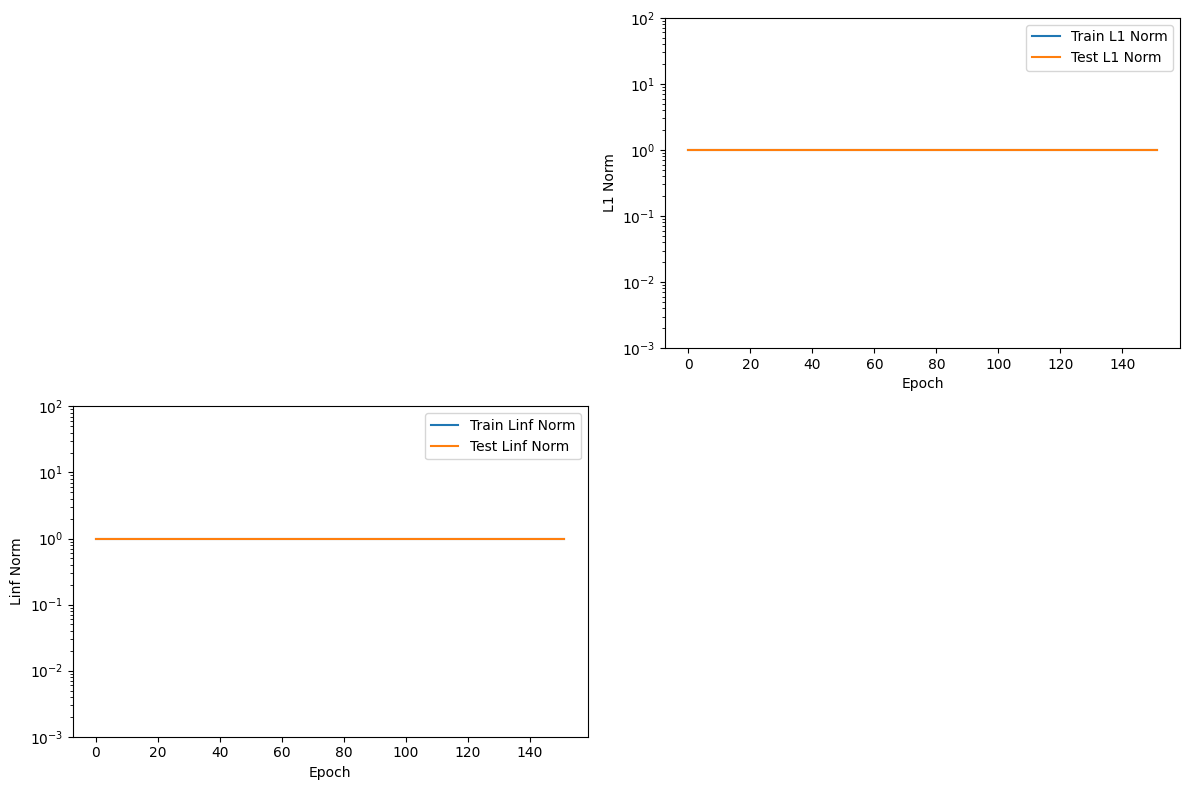

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'MSE')

(1e-07, 1.0)

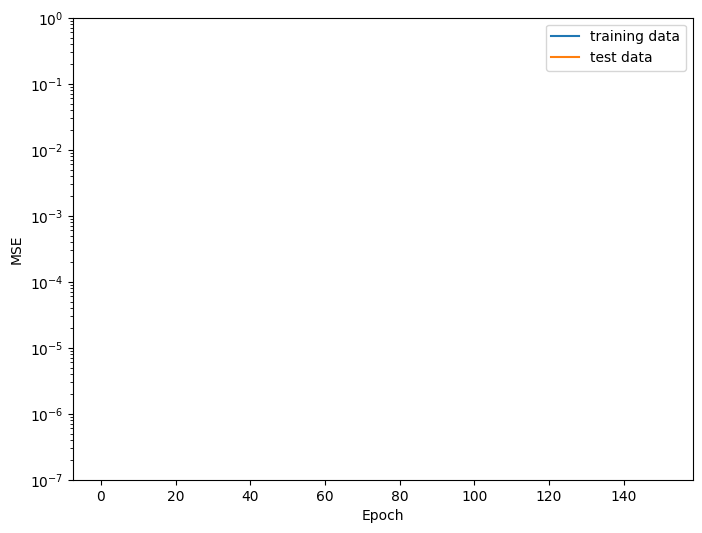

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
optimizer_loaded_state_dict = torch.load("optimizer.pth")
if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
scheduler_loaded_state_dict = torch.load("scheduler.pth")
if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

<All keys matched successfully>

In [ ]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

49

152

'Huber'

'RMSprop'

'ReduceLROnPlateau'

[555, 458, 115]

3

'ReLU'

'ReLU'

0.000122770896701404

ReLU()

ReLU()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('hidden_activation', ReLU()),
              ('output_activation', ReLU()),
              ('layers',
               ModuleList(
                 (0): Linear(in_features=3, out_features=555, bias=True)
                 (1): Linear(in_features=555, out_features=458, bias=True)
                 (2): Linear(in_features=458, out_features=115, bias=True)
                 (3): Linear(in_features=115, out_features=1

SmoothL1Loss()

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 5.738287568126183e-09
    maximize: False
    momentum: 0
    weight_decay: 0
)

{'defaults': {'lr': 0.000122770896701404,
  'momentum': 0,
  'alpha': 0.99,
  'eps': 1e-08,
  'centered': False,
  'weight_decay': 0,
  'foreach': None,
  'maximize': False,
  'differentiable': False},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#RMSprop.zero_grad',
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([[ 0.4374,  0.2126,  0.5091],
                      [ 0.1803, -0.1230,  0.0888],
                      [-0.5235,  0.3780,  0.3915],
                      ...,
                      [ 0.1948, -0.4153,  0.0342],
                      [ 0.3068, -0.0605, -0.2590],
                      [ 0.4539, -0.4890, -0.2324]], device='cuda:0', requires_grad=True): {'step': 248216,
               'square_avg': tensor([[0., 0., 0.],
                       [0., 0., 0.],
                       [0., 0., 0.],
                       ...,
                       [0., 0., 

{'factor': 0.18979341786654758,
 'optimizer': RMSprop (
 Parameter Group 0
     alpha: 0.99
     centered: False
     differentiable: False
     eps: 1e-08
     foreach: None
     lr: 5.738287568126183e-09
     maximize: False
     momentum: 0
     weight_decay: 0
 ),
 'min_lrs': [0],
 'patience': 11,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0017197466122611932,
 'threshold_mode': 'rel',
 'best': 2.9469303179740907,
 'num_bad_epochs': 7,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 152,
 '_last_lr': [5.738287568126183e-09]}

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"


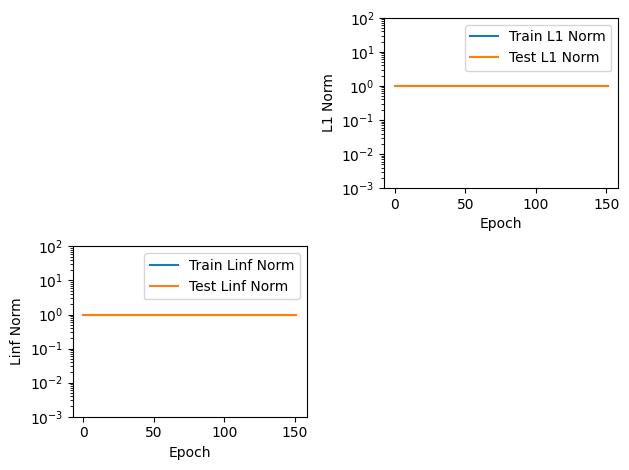

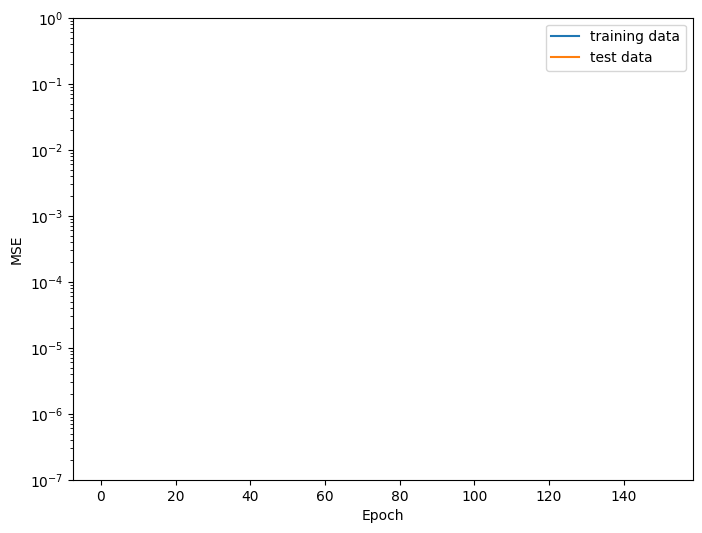

In [ ]:

# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [ ]:
print(list(net.parameters()))

[Parameter containing:
tensor([[ 0.4374,  0.2126,  0.5091],
        [ 0.1803, -0.1230,  0.0888],
        [-0.5235,  0.3780,  0.3915],
        ...,
        [ 0.1948, -0.4153,  0.0342],
        [ 0.3068, -0.0605, -0.2590],
        [ 0.4539, -0.4890, -0.2324]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.5592, -0.5716,  0.3932, -0.0678,  0.1885,  0.4598, -0.3819, -0.2115,
        -0.2385, -0.2690,  0.5006,  0.5340,  0.4853,  0.3576, -0.1075,  0.3707,
        -0.3181,  0.3755,  0.3382,  0.4471,  0.2976, -0.4094,  0.4940,  0.2854,
        -0.5699, -0.0209,  0.0734,  0.2243, -0.3747, -0.3686, -0.1902, -0.2280,
         0.1116, -0.3076, -0.5156,  0.1564, -0.3949, -0.1530, -0.2411, -0.4875,
         0.3072, -0.0141, -0.3995,  0.5146, -0.4203,  0.5034,  0.2648,  0.0777,
         0.0213, -0.5024,  0.1752,  0.3375, -0.5494, -0.4547, -0.0360,  0.5296,
        -0.0467, -0.3412, -0.0256,  0.0589, -0.3507,  0.1389,  0.2645, -0.4623,
         0.3869,  0.4904, -0.4165, -0.259

In [ ]:
print(list(net_loaded.parameters()))

[Parameter containing:
tensor([[ 0.4374,  0.2126,  0.5091],
        [ 0.1803, -0.1230,  0.0888],
        [-0.5235,  0.3780,  0.3915],
        ...,
        [ 0.1948, -0.4153,  0.0342],
        [ 0.3068, -0.0605, -0.2590],
        [ 0.4539, -0.4890, -0.2324]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.5592, -0.5716,  0.3932, -0.0678,  0.1885,  0.4598, -0.3819, -0.2115,
        -0.2385, -0.2690,  0.5006,  0.5340,  0.4853,  0.3576, -0.1075,  0.3707,
        -0.3181,  0.3755,  0.3382,  0.4471,  0.2976, -0.4094,  0.4940,  0.2854,
        -0.5699, -0.0209,  0.0734,  0.2243, -0.3747, -0.3686, -0.1902, -0.2280,
         0.1116, -0.3076, -0.5156,  0.1564, -0.3949, -0.1530, -0.2411, -0.4875,
         0.3072, -0.0141, -0.3995,  0.5146, -0.4203,  0.5034,  0.2648,  0.0777,
         0.0213, -0.5024,  0.1752,  0.3375, -0.5494, -0.4547, -0.0360,  0.5296,
        -0.0467, -0.3412, -0.0256,  0.0589, -0.3507,  0.1389,  0.2645, -0.4623,
         0.3869,  0.4904, -0.4165, -0.259

In [ ]:
# Set the network to evaluation mode
net.eval()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

In [ ]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

tensor([[1.5106e+00, 1.6111e-01, 1.3958e+00],
        [1.8810e+00, 1.4456e+00, 1.4271e+00],
        [6.3549e+00, 1.3628e+01, 1.6223e+01],
        [2.8971e+00, 3.5144e-01, 1.6518e+00],
        [7.2380e+00, 1.1534e+01, 9.5735e+00],
        [2.1410e+00, 1.0915e-02, 9.9581e-01],
        [4.6514e+00, 1.2338e+01, 1.0527e+01],
        [1.1167e+01, 2.2953e+01, 2.4298e+01],
        [5.9498e+00, 1.8114e+01, 1.6891e+01],
        [1.3202e+00, 4.4314e+00, 4.0692e+00],
        [6.0542e+00, 1.6220e+00, 1.8779e+00],
        [8.1758e+00, 4.1028e+00, 1.5419e+01],
        [4.9754e+00, 8.4841e+00, 1.0742e+01],
        [7.8301e+00, 7.6014e+00, 3.3196e+00],
        [6.5565e+00, 1.0051e+01, 1.2204e+01],
        [8.5381e+00, 1.8456e+01, 1.4936e+01],
        [3.9177e+00, 5.8831e-01, 1.5410e+00],
        [1.0078e+01, 7.3127e+00, 5.7252e+00],
        [6.5736e+00, 1.5045e+00, 2.8418e+00],
        [1.7163e+00, 5.0971e-03, 6.0436e-01]], device='cuda:0')

In [ ]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

[tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', 

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

[tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', 

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)

tensor([[0.6343, 1.1464, 1.8773]], device='cuda:0')

tensor([[5.6567, 2.1899, 9.0629]], device='cuda:0')

tensor([[0.]], device='cuda:0', grad_fn=<ReluBackward0>)